# CLAIM 1

Here is the code for reproduction of claim 1, which corresponds to experiment 1.

In [1]:
## IMPORTS

# import standard data science libraries
import numpy as np
import pandas as pd

# import ggplot for graphing
import plotnine
from plotnine import ggplot, aes, geom_line, geom_point, geom_errorbar, \
                     facet_wrap, position_dodge, theme, geom_violin, xlab, ylab, \
                     coord_flip, geom_bar, element_text, scale_x_discrete, scale_fill_manual, \
                     geom_hline, xlim, ylim, scale_color_discrete, geom_text, position_stack

# suppress any warnings
import warnings

# import helper functions
from helper_functions import plot_fig_4, likelihood_of_being_better, likelihood_of_improvement

## CONSTANTS

# 95-percentile
Q_95 = 1.00 

## Claim 1.1 (HS is better than DT)

#### Regression

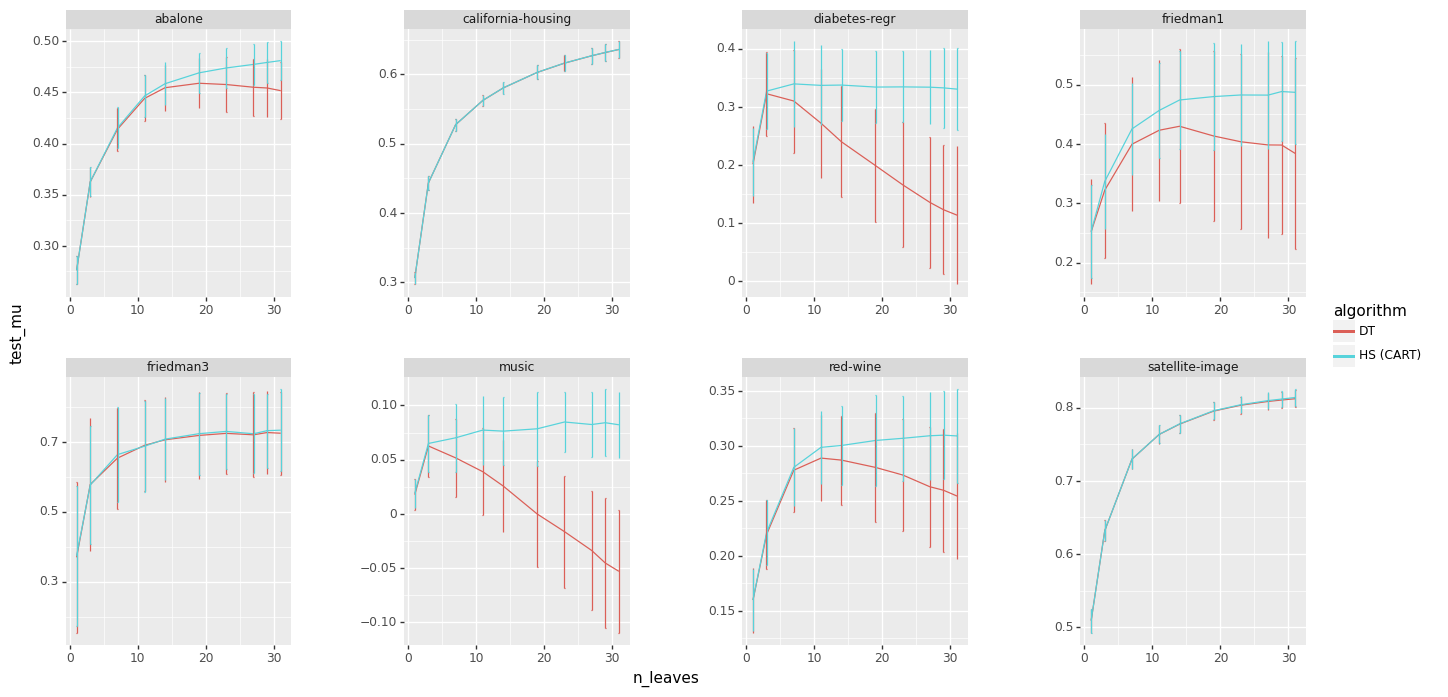

<ggplot: (8745814895001)>

In [2]:
# load regression dataset
regression = pd.read_csv("results/claim_1_1_dt_comparison_regression.csv")    

# plot results in similar fashion to the original paper
plot_fig_4(regression)

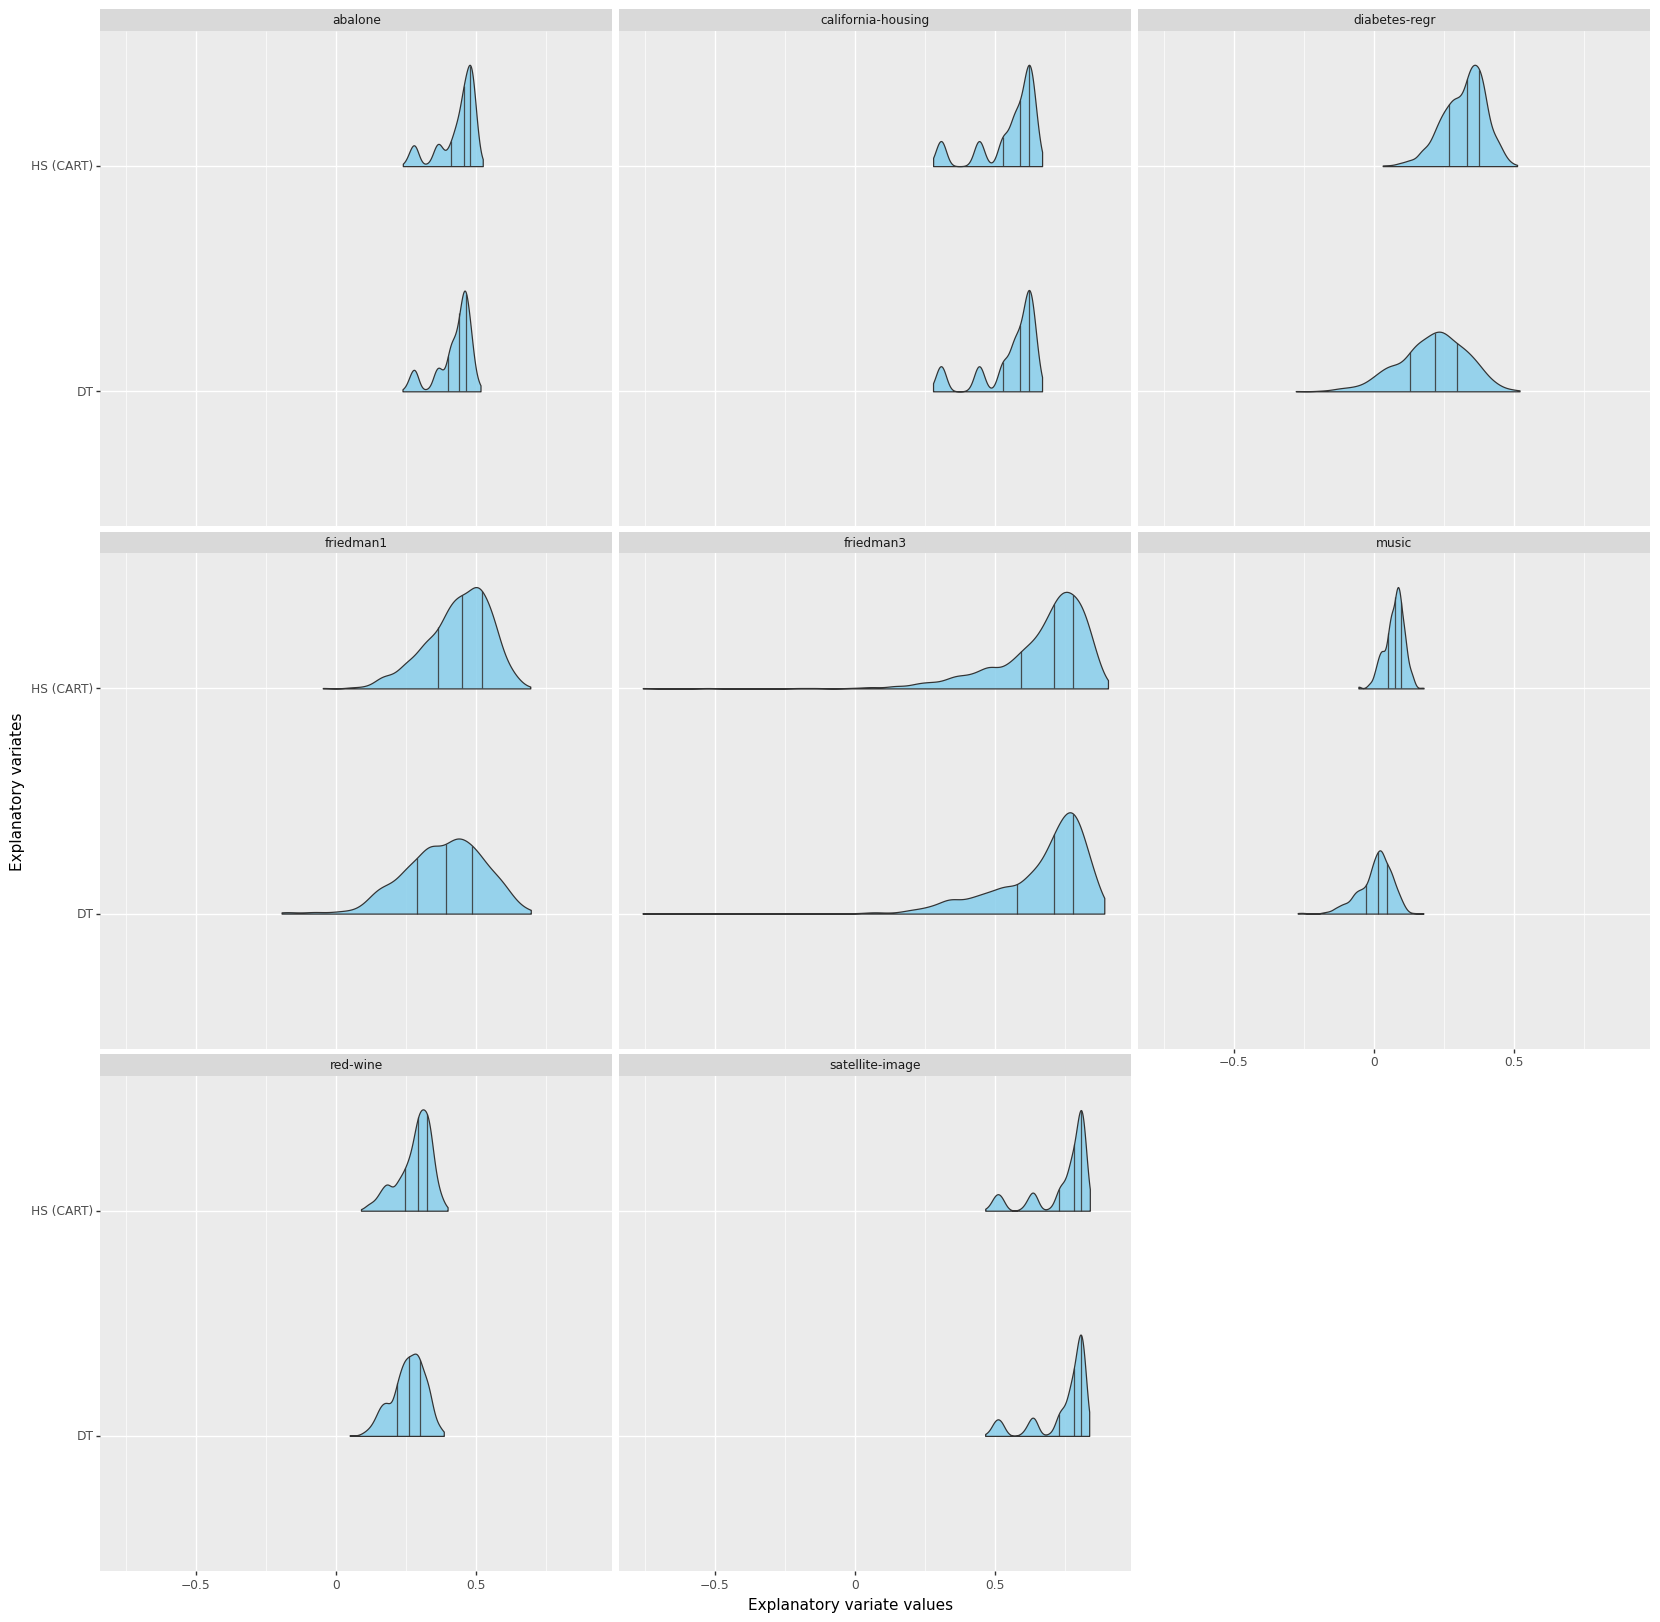

<ggplot: (8745811593021)>

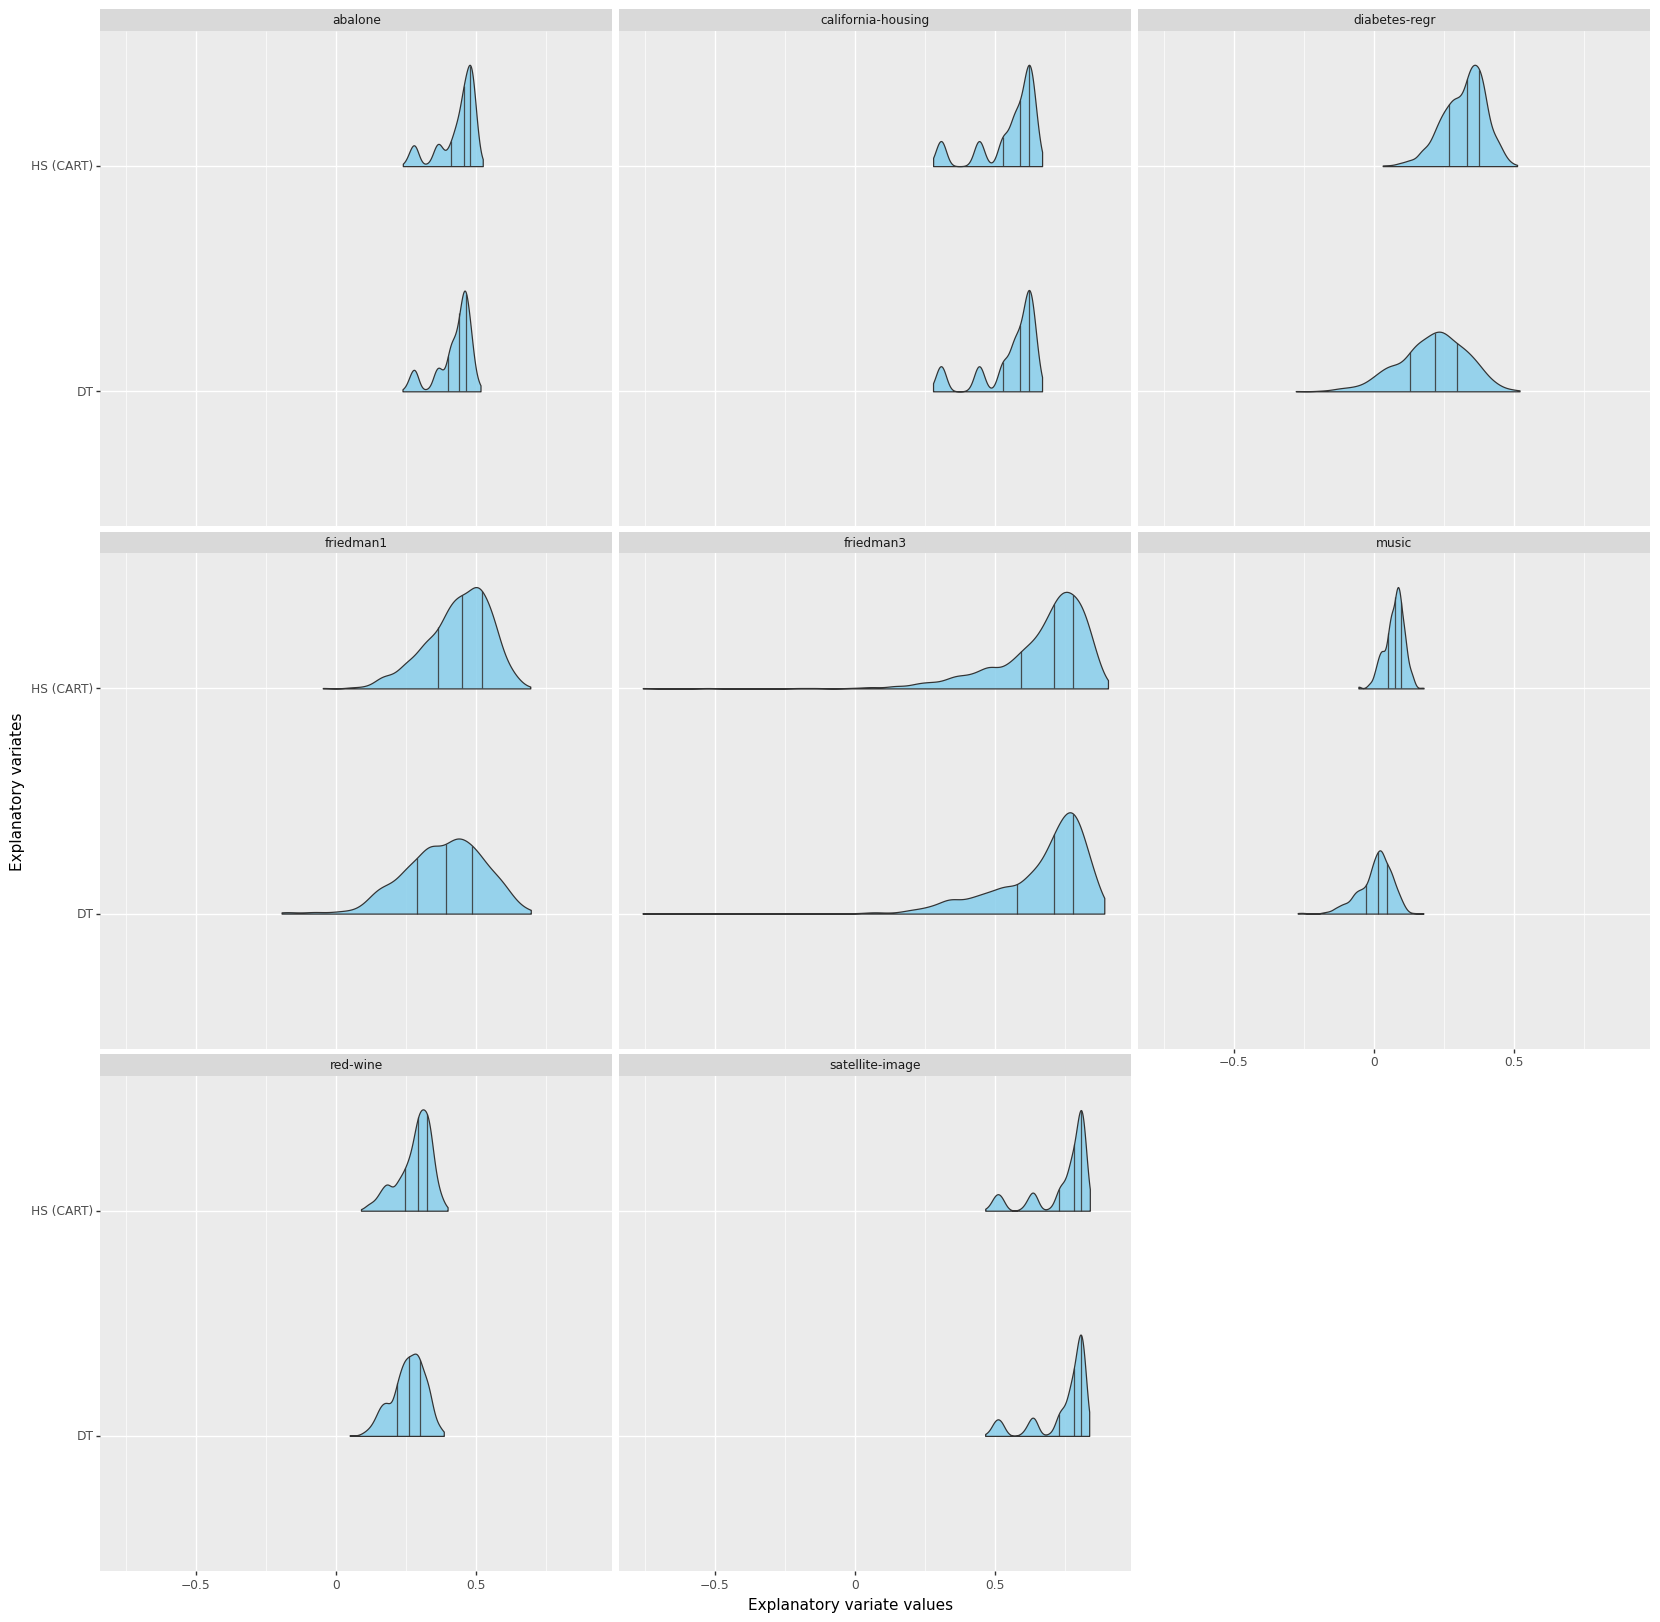

<ggplot: (8745812287822)>

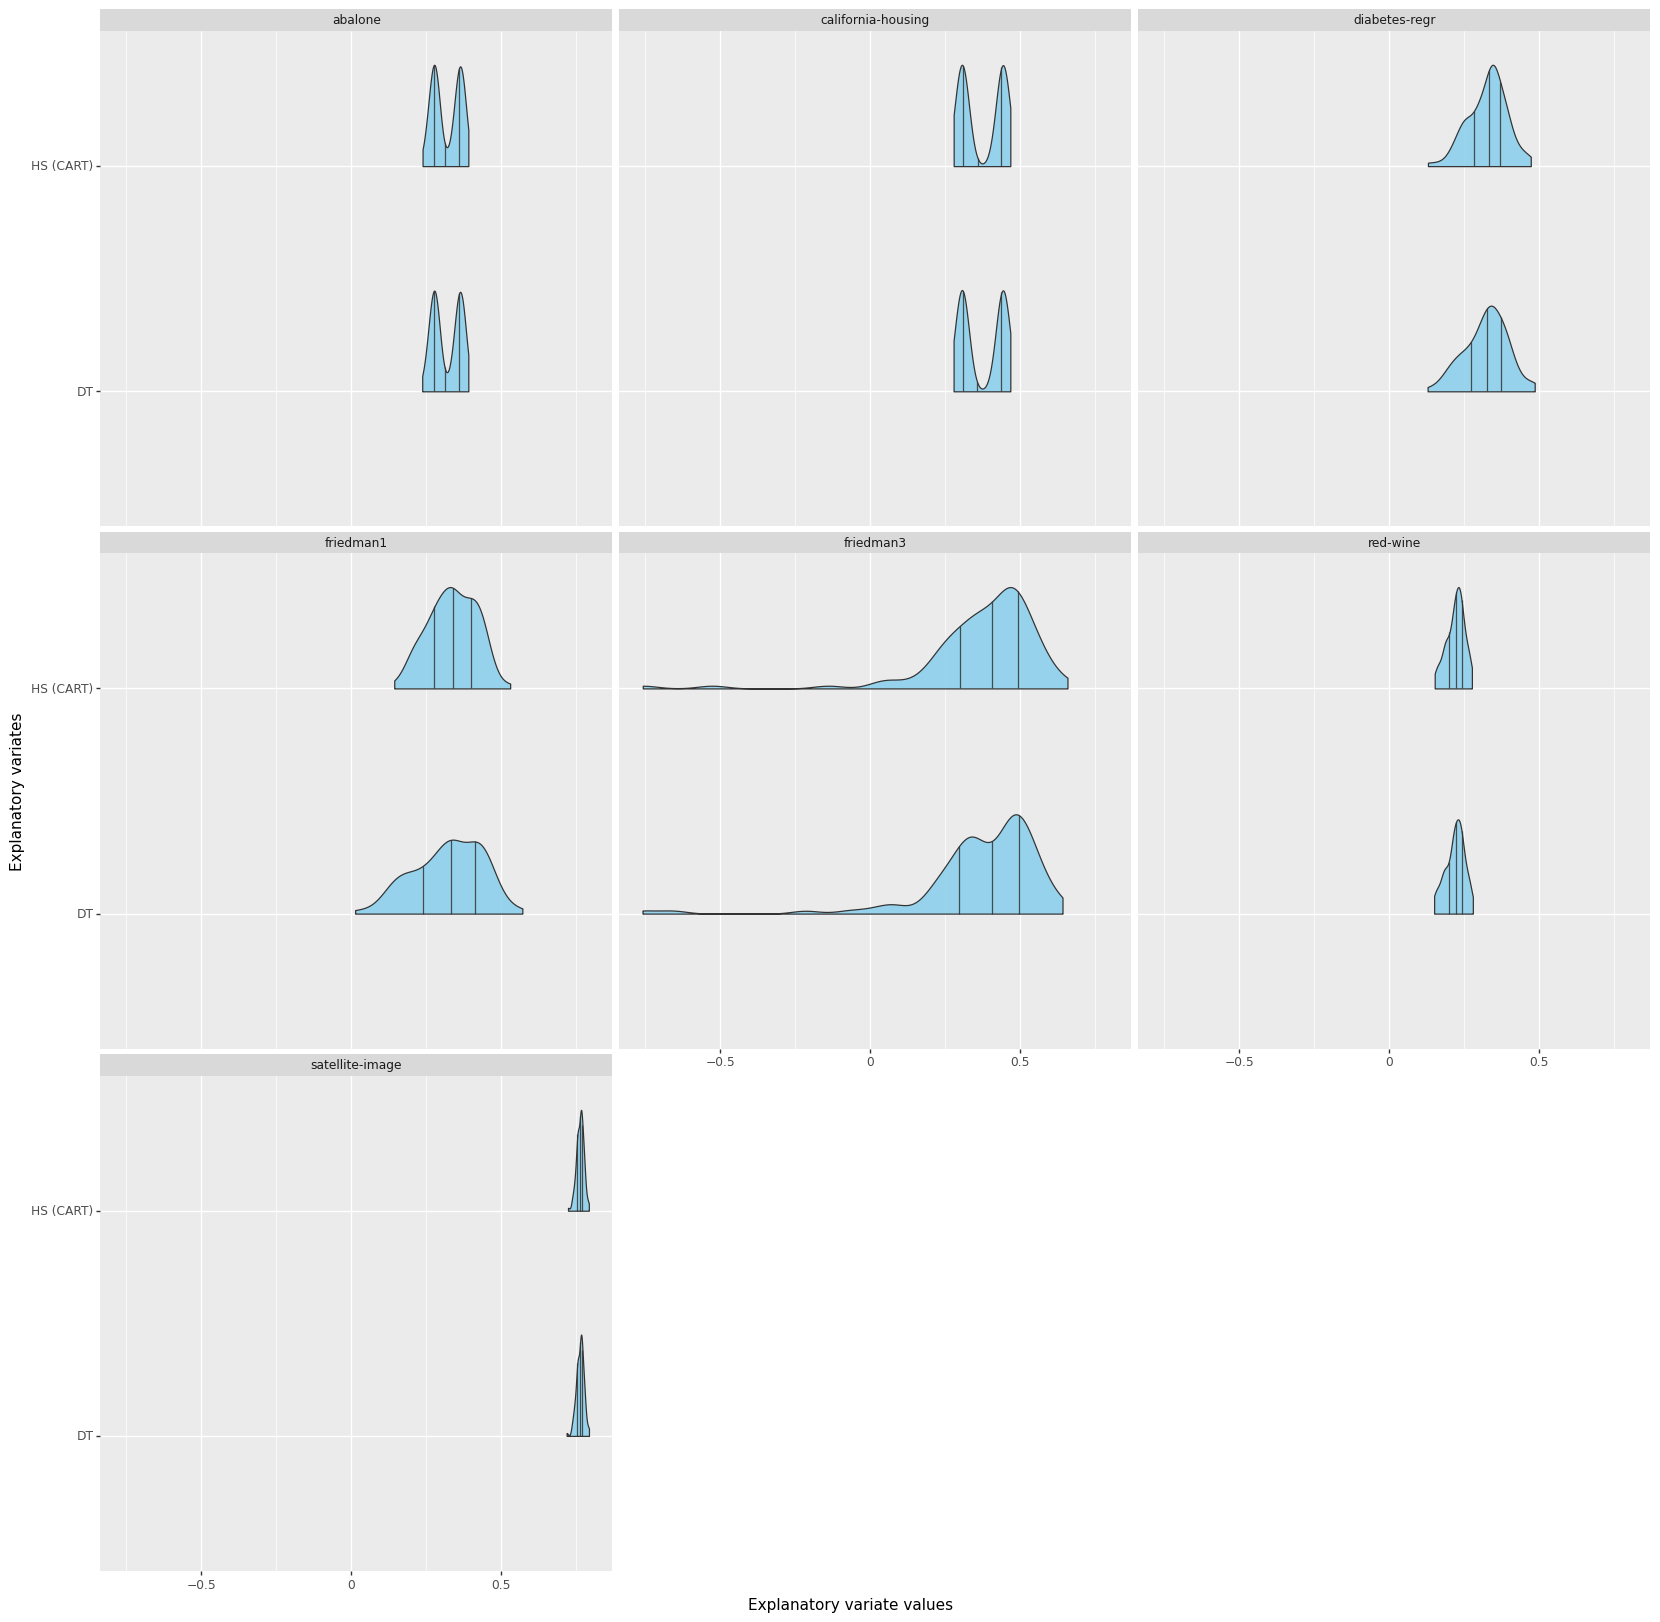

<ggplot: (8745809816910)>

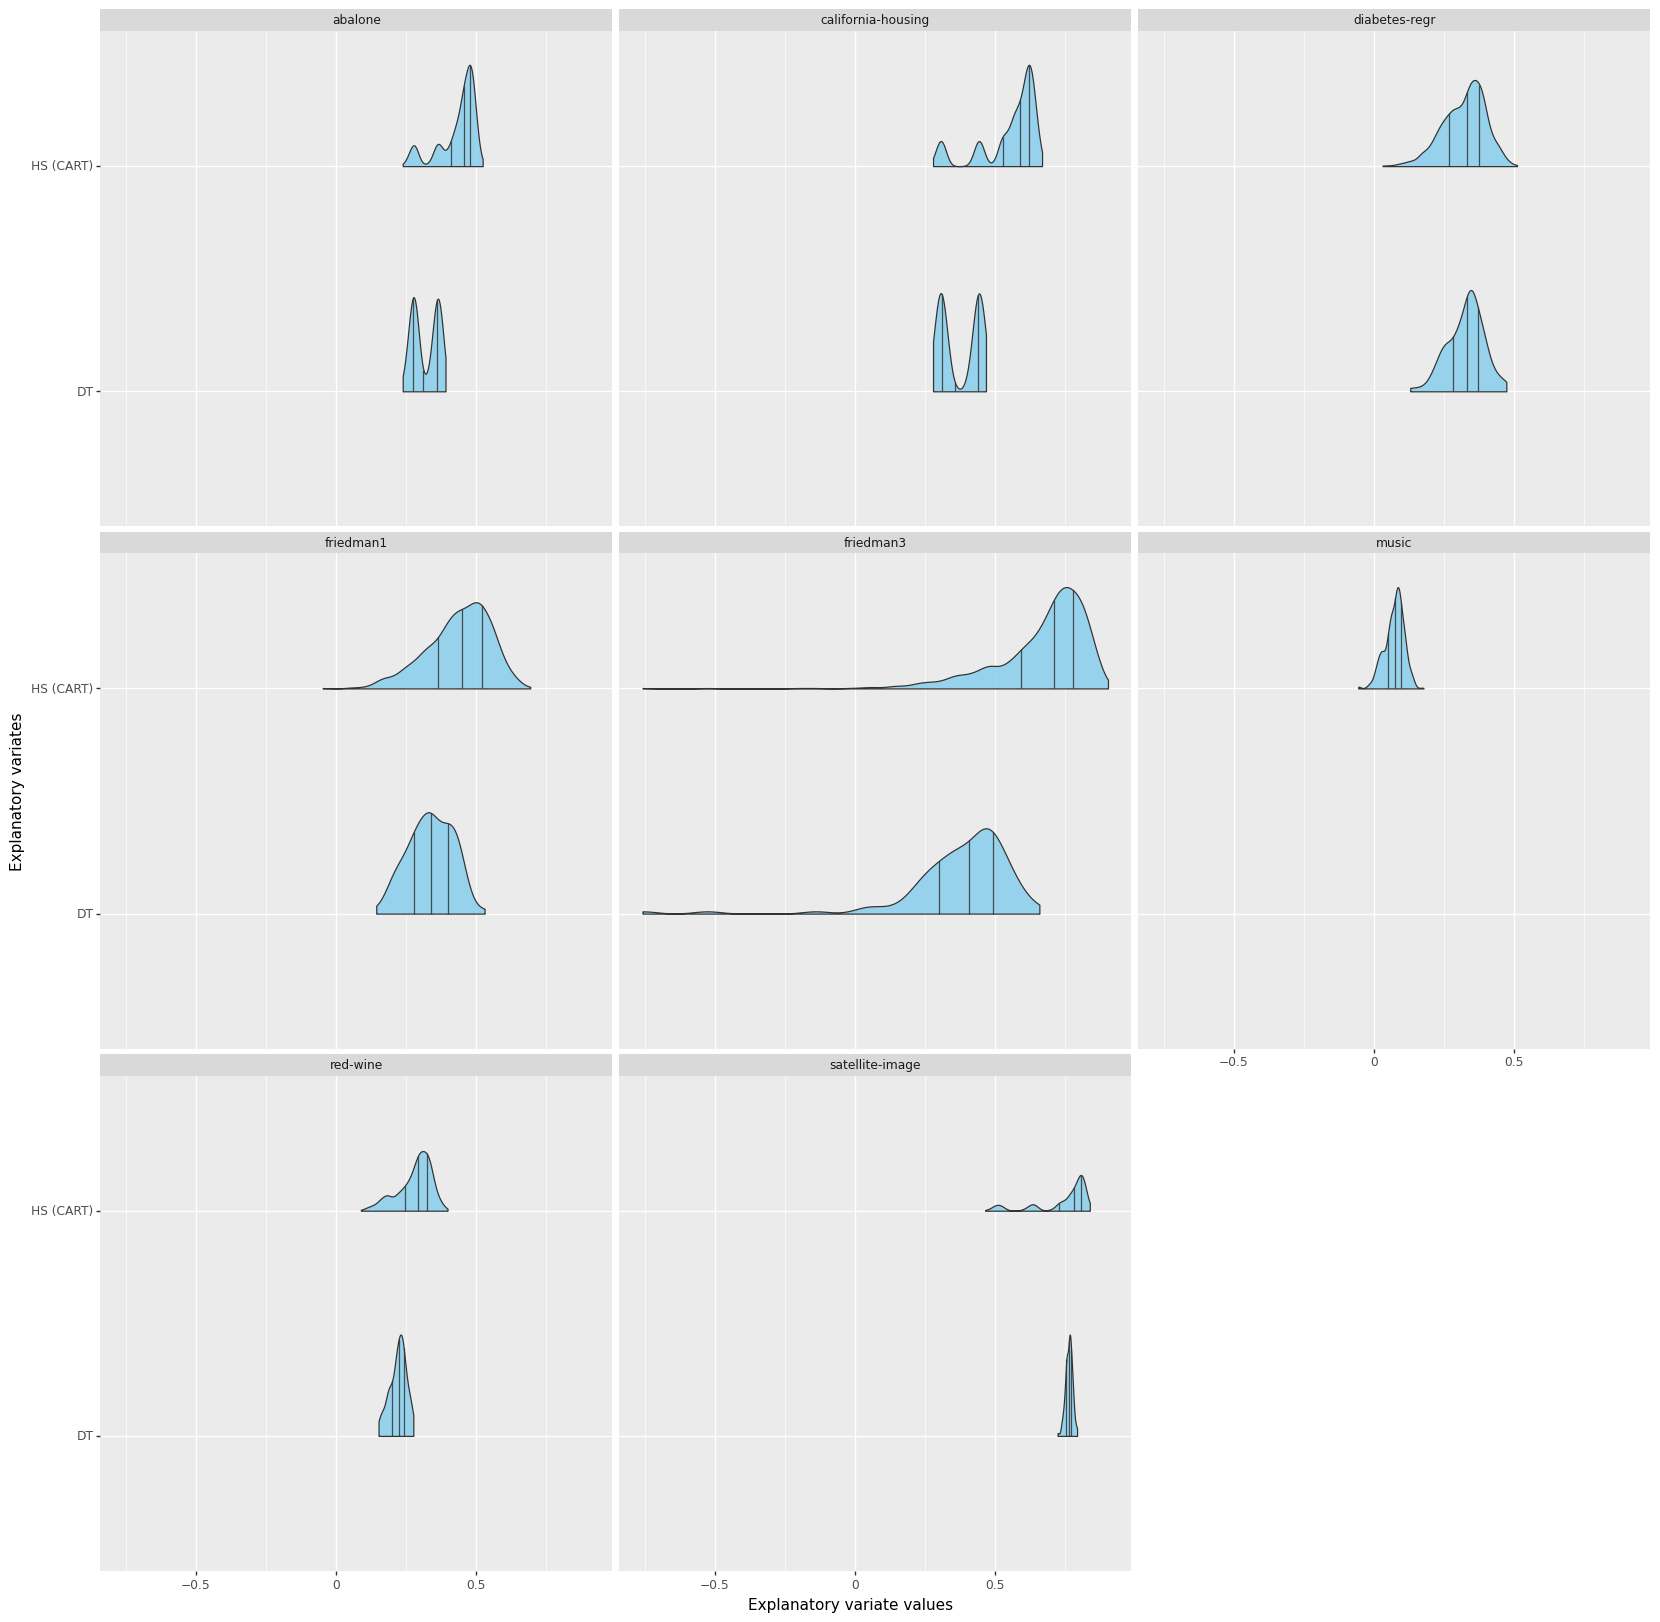

<ggplot: (8745811961553)>

In [3]:
# change plotnine size for easier visualization
plotnine.options.figure_size = (20, 20)

### Pick top best n-scores from HS-DT and DT (95 % quantile)

top_scores = {algorithm: {dataset: [] for dataset in np.unique(regression["dataset"])} for algorithm in np.unique(regression["algorithm"])}

# traverse through all groups of (algorithm, dataset)
for algorithm in np.unique(regression["algorithm"]):
    for dataset in np.unique(regression["dataset"]):
        # sort values in each group from largest to smallest
        scores = regression.loc[(regression["algorithm"] == algorithm) & (regression["dataset"] == dataset)].sort_values(["test_score"], ascending = False)["test_score"].to_numpy()
        
        # pick only the top quantile scores from each group
        num_scores = len(scores)
        top_percentile = int(np.round(Q_95 * num_scores))
        top_score = scores[:top_percentile]
        
        # store results
        top_scores[algorithm][dataset] = top_score

# convert results to dataset
top_disp = pd.DataFrame(columns = ["algorithm", "dataset", "test_score"])
        
for algorithm in np.unique(regression["algorithm"]):
    for dataset in np.unique(regression["dataset"]):
        for score in top_scores[algorithm][dataset]:
            top_disp = pd.concat([top_disp, pd.DataFrame({"algorithm": [algorithm], "dataset": [dataset], "test_score": score})])
            
# calculate likelihood that HS-DT is better than DT
top_improvement = {dataset: None  for dataset in np.unique(regression["dataset"])}
for dataset in np.unique(regression["dataset"]):
    # get top results for each algorithm
    top_subset_dt = top_disp.loc[(top_disp["algorithm"] == "DT") & (top_disp["dataset"] == dataset)]
    top_subset_hs = top_disp.loc[(top_disp["algorithm"] == "HS (CART)") & (top_disp["dataset"] == dataset)]
    # compare randomly sampled pairs of top results which one is better
    top_improvement[dataset] = likelihood_of_being_better(np.array(top_subset_dt["test_score"]), np.array(top_subset_hs["test_score"]))

### Check how likely it is that HS-CART will give you a better result than CART day-to-day
any_improvement = {dataset: None  for dataset in np.unique(regression["dataset"])}
    
for dataset in np.unique(regression["dataset"]):
    # get top results for each algorithm 
    any_subset_dt = regression.loc[(regression["algorithm"] == "DT") & (regression["dataset"] == dataset)]
    any_subset_hs = regression.loc[(regression["algorithm"] == "HS (CART)") & (regression["dataset"] == dataset)]
    # compare tuples of results which one is better
    any_improvement[dataset] = likelihood_of_improvement(np.array(any_subset_dt["test_score"]), np.array(any_subset_hs["test_score"]))
        
### Check how likely it is that using default parameters someone will get a better reults using HS-CART than CART

TOL_LEAF = 2 # tolarence for deviation from ideal num. of leaves

# default leaf values sqrt(num. of features)
leaf_heuristic = {"friedman1": np.floor(10/3),
                  "friedman3": np.floor(4/3),
                  "diabetes-regr": np.floor(10/3),
                  "music": np.floor(117/3),
                  "red-wine": np.floor(11/3),
                  "abalone": np.floor(8/3),
                  "satellite-image": np.floor(36/3),
                  "california-housing": np.floor(8/3)}

heuristic_scores = regression.copy()
heuristic_scores = {algorithm: {dataset: [] for dataset in np.unique(regression["dataset"])} for algorithm in np.unique(regression["algorithm"])}

# for each group (algorithm, dataset)
for dataset in np.unique(regression["dataset"]):
    n_leaves = leaf_heuristic[dataset]
    for algorithm in np.unique(regression["algorithm"]):
        # pick points near ideal number of leaves
        heuristic_scores[algorithm][dataset] = np.array(regression.loc[(regression["algorithm"] == algorithm) & (regression["dataset"] == dataset) & (np.abs(regression["n_leaves"] - n_leaves) < TOL_LEAF)]["test_score"])

# convert dictionary to dataset
heuristic_disp = pd.DataFrame(columns = ["algorithm", "dataset", "test_score"])
        
for algorithm in np.unique(regression["algorithm"]):
    for dataset in np.unique(regression["dataset"]):
        for score in heuristic_scores[algorithm][dataset]:
            heuristic_disp = pd.concat([heuristic_disp, pd.DataFrame({"algorithm": [algorithm], "dataset": [dataset], "test_score": score})])

# calculate likelihood of improvement
heuristic_improvement = {dataset: None  for dataset in np.unique(regression["dataset"])}
for dataset in np.unique(regression["dataset"]):
    # split points based on dataset
    heuristic_subset_dt = heuristic_disp.loc[(heuristic_disp["algorithm"] == "DT") & (heuristic_disp["dataset"] == dataset)]
    heuristic_subset_hs = heuristic_disp.loc[(heuristic_disp["algorithm"] == "HS (CART)") & (heuristic_disp["dataset"] == dataset)]
    # compare randomly sampled pairs of results which one is better
    heuristic_improvement[dataset] = likelihood_of_improvement(np.array(heuristic_subset_dt["test_score"]), np.array(heuristic_subset_hs["test_score"]))
            
# default / proposed # of features
baseline_scores = regression.copy()

baseline_scores = {algorithm: {dataset: [] for dataset in np.unique(regression["dataset"])} for algorithm in np.unique(regression["algorithm"])}

for dataset in np.unique(regression["dataset"]):
    n_leaves = leaf_heuristic[dataset]
    baseline_scores["DT"][dataset] = np.array(regression.loc[(regression["algorithm"] == algorithm) & (regression["dataset"] == dataset) & (np.abs(regression["n_leaves"] - n_leaves) < TOL_LEAF)]["test_score"])
    baseline_scores["HS (CART)"][dataset] = np.array(regression.loc[(regression["algorithm"] == algorithm) & (regression["dataset"] == dataset)]["test_score"])
        
baseline_disp = pd.DataFrame(columns = ["algorithm", "dataset", "test_score"])
        
for algorithm in np.unique(regression["algorithm"]):
    for dataset in np.unique(regression["dataset"]):
        for score in baseline_scores[algorithm][dataset]:
            baseline_disp = pd.concat([baseline_disp, pd.DataFrame({"algorithm": [algorithm], "dataset": [dataset], "test_score": score})])
            
baseline_improvement = {dataset: None  for dataset in np.unique(regression["dataset"])}
for dataset in np.unique(regression["dataset"]):
    baseline_subset_dt = baseline_disp.loc[(baseline_disp["algorithm"] == "DT") & (baseline_disp["dataset"] == dataset)]
    baseline_subset_hs = baseline_disp.loc[(baseline_disp["algorithm"] == "HS (CART)") & (baseline_disp["dataset"] == dataset)]
    baseline_improvement[dataset] = likelihood_of_being_better(np.array(baseline_subset_dt["test_score"]), np.array(baseline_subset_hs["test_score"]))
            
# probability as a function of leaves
leaf_scores = {algorithm: {dataset: {n_leaves: None for n_leaves in np.unique(regression["n_leaves"])} for dataset in np.unique(regression["dataset"])} for algorithm in np.unique(regression["algorithm"])}
for algorithm in np.unique(regression["algorithm"]):
    for dataset in np.unique(regression["dataset"]):
        for n_leaves in np.unique(regression["n_leaves"]):
            leaf_scores[algorithm][dataset][n_leaves] = np.array(regression.loc[(regression["algorithm"] == algorithm) & (regression["dataset"] == dataset) & (np.abs(regression["n_leaves"] - n_leaves) < 0.5)]["test_score"])

leaf_disp = pd.DataFrame(columns = ["algorithm", "dataset", "test_score"])

for algorithm in np.unique(regression["algorithm"]):
    for dataset in np.unique(regression["dataset"]):
        for n_leaves in np.unique(regression["n_leaves"]):
            for score in leaf_scores[algorithm][dataset][n_leaves]:
                leaf_disp = pd.concat([leaf_disp, pd.DataFrame({"algorithm": [algorithm], "dataset": [dataset], "n_leaves": n_leaves, "test_score": score})])

leaf_improvement = {dataset: {n_leaves: None for n_leaves in np.unique(regression["n_leaves"])}  for dataset in np.unique(regression["dataset"])}
for dataset in np.unique(regression["dataset"]):
    for n_leaves in np.unique(regression["n_leaves"]):
        leaf_subset_dt = leaf_disp.loc[(leaf_disp["algorithm"] == "DT") & (leaf_disp["dataset"] == dataset)]
        leaf_subset_hs = leaf_disp.loc[(leaf_disp["algorithm"] == "HS (CART)") & (leaf_disp["dataset"] == dataset)]
        leaf_improvement[dataset][n_leaves] = likelihood_of_being_better(np.array(leaf_subset_dt["test_score"]), np.array(leaf_subset_hs["test_score"]))
                
with warnings.catch_warnings(record=True) as future_warn:    
    g = (
        ggplot(top_disp, aes(x="algorithm", y="test_score"))
        + geom_violin(draw_quantiles = [0.25, 0.5, 0.75], fill = "skyblue", alpha = 0.85, style = "right", position = position_dodge())
        + ylab("Explanatory variate values")
        + xlab("Explanatory variates")
        + coord_flip()
        + facet_wrap("dataset")
    )
    
    display(g)
    g.save(filename = "graphs/DT-regression-all-comparison.png", height = 5, width = 5, units = "in", dpi = 1000)

    # pick all scores from HS-DT
    g = (
        ggplot(regression, aes(x="algorithm", y="test_score"))
        + geom_violin(draw_quantiles = [0.25, 0.5, 0.75], fill = "skyblue", alpha = 0.85, style = "right", position = position_dodge())
        + ylab("Explanatory variate values")
        + xlab("Explanatory variates")
        + coord_flip()
        + facet_wrap("dataset")
    )
    display(g)
    g.save(filename = "graphs/DT-regression-any-comparison.png", height = 5, width = 5, units = "in", dpi = 1000)    
    
    g = (
        ggplot(heuristic_disp, aes(x="algorithm", y="test_score"))
        + geom_violin(draw_quantiles = [0.25, 0.5, 0.75], fill = "skyblue", alpha = 0.85, style = "right", position = position_dodge())
        + ylab("Explanatory variate values")
        + xlab("Explanatory variates")
        + coord_flip()
        + facet_wrap("dataset")
    )
    
    display(g)
    g.save(filename = "graphs/DT-regression-heuristic-comparison.png", height = 5, width = 5, units = "in", dpi = 1000)
    
    g = (
        ggplot(baseline_disp, aes(x="algorithm", y="test_score"))
        + geom_violin(draw_quantiles = [0.25, 0.5, 0.75], fill = "skyblue", alpha = 0.85, style = "right", position = position_dodge())
        + ylab("Explanatory variate values")
        + xlab("Explanatory variates")
        + coord_flip()
        + facet_wrap("dataset")
    )
    
    display(g)
    g.save(filename = "graphs/DT-regression-baseline-comparison.png", height = 5, width = 5, units = "in", dpi = 1000)

Top


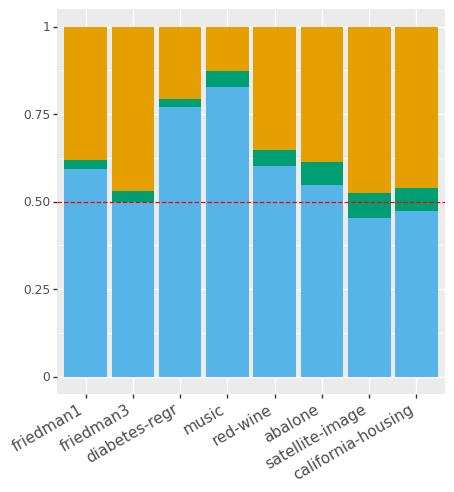

<ggplot: (8767566300707)>

/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 5 x 5 in image.
/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: graphs/DT-top-likelihood.png


Any


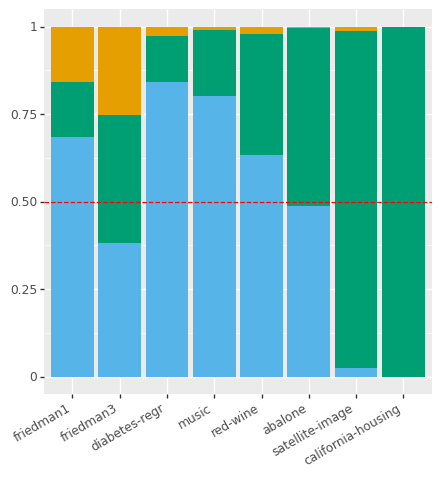

<ggplot: (8767566291932)>

/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 5 x 5 in image.
/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: graphs/DT-any-likelihood.png


Heuristic


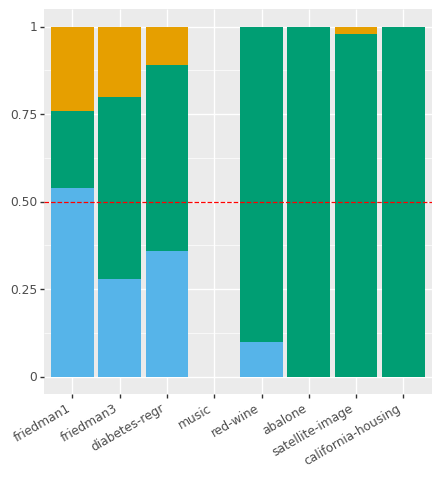

<ggplot: (8767568332068)>

/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 5 x 5 in image.
/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: graphs/DT-heauristic-likelihood.png


Leaves


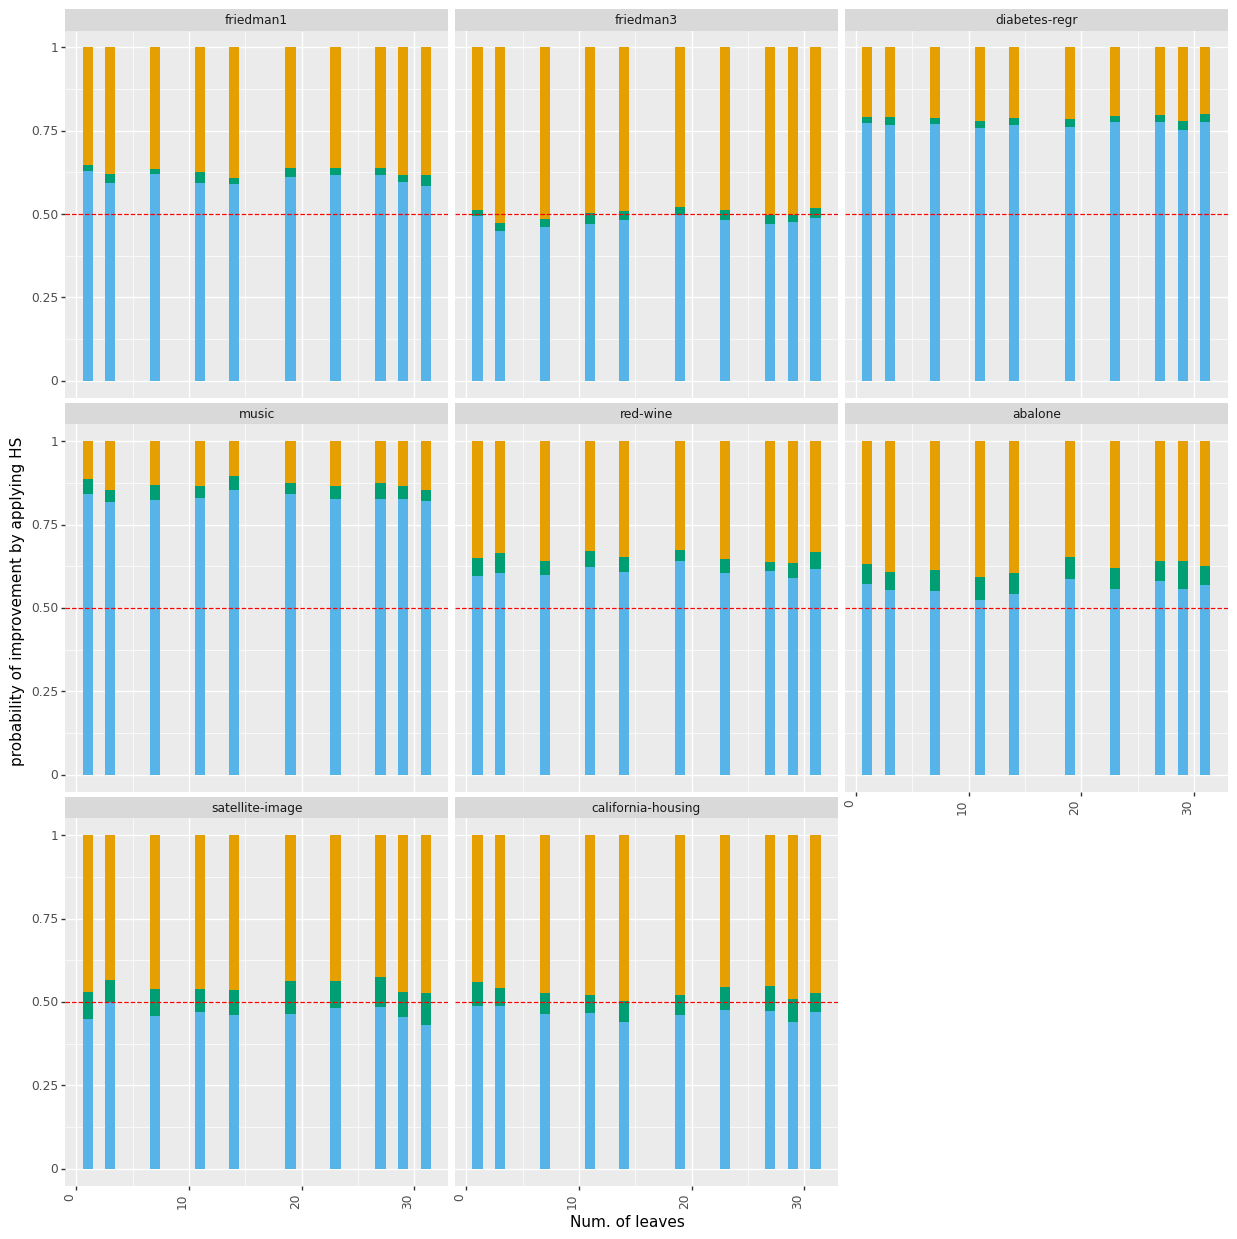

<ggplot: (8767568831083)>

/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 5 x 5 in image.
/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: graphs/DT-leaf-likelihood.png


In [4]:
top_imp_disp = {"dataset": [], "better": [], "worse": [], "same": []}
dataset_order = ["friedman1", "friedman3", "diabetes-regr", "music", \
                 "red-wine", "abalone", "satellite-image", "california-housing"]

for dataset in top_improvement.keys():
    top_imp_disp["dataset"].append(dataset)
    top_imp_disp["better"].append(top_improvement[dataset][0])
    top_imp_disp["same"].append(top_improvement[dataset][1])
    top_imp_disp["worse"].append(top_improvement[dataset][2])
top_imp_disp = pd.DataFrame(top_imp_disp)

top_imp_disp = pd.melt(top_imp_disp, id_vars=['dataset'], value_vars=['better', "same", 'worse'])
top_imp_disp["dataset"] = pd.Categorical(top_imp_disp["dataset"], categories = dataset_order, ordered = True)
top_imp_disp["variable"] = pd.Categorical(top_imp_disp["variable"], categories = ['worse', "same", 'better'], ordered = True)

any_imp_disp = {"dataset": [], "better": [], "worse": [], "same": []}

for dataset in top_improvement.keys():
    any_imp_disp["dataset"].append(dataset)
    any_imp_disp["better"].append(any_improvement[dataset][0])
    any_imp_disp["same"].append(any_improvement[dataset][1])
    any_imp_disp["worse"].append(any_improvement[dataset][2])
any_imp_disp = pd.DataFrame(any_imp_disp)

any_imp_disp = pd.melt(any_imp_disp, id_vars=['dataset'], value_vars=['better', "same", 'worse'])
any_imp_disp["dataset"] = pd.Categorical(any_imp_disp["dataset"], categories = dataset_order, ordered = True)
any_imp_disp["variable"] = pd.Categorical(any_imp_disp["variable"], categories = ['worse', "same", 'better'], ordered = True)

heuristic_imp_disp = {"dataset": [], "better": [], "worse": [], "same": []}

for dataset in heuristic_improvement.keys():
    heuristic_imp_disp["dataset"].append(dataset)
    heuristic_imp_disp["better"].append(heuristic_improvement[dataset][0])
    heuristic_imp_disp["same"].append(heuristic_improvement[dataset][1])
    heuristic_imp_disp["worse"].append(heuristic_improvement[dataset][2])
heuristic_imp_disp = pd.DataFrame(heuristic_imp_disp)

heuristic_imp_disp = pd.melt(heuristic_imp_disp, id_vars=['dataset'], value_vars=['better', "same", 'worse'])
heuristic_imp_disp["dataset"] = pd.Categorical(heuristic_imp_disp["dataset"], categories = dataset_order, ordered = True)
heuristic_imp_disp["variable"] = pd.Categorical(heuristic_imp_disp["variable"], categories = ['worse', "same", 'better'], ordered = True)

baseline_imp_disp = {"dataset": [], "better": [], "worse": [], "same": []}

for dataset in baseline_improvement.keys():
    baseline_imp_disp["dataset"].append(dataset)
    baseline_imp_disp["better"].append(baseline_improvement[dataset][0])
    baseline_imp_disp["same"].append(baseline_improvement[dataset][1])
    baseline_imp_disp["worse"].append(baseline_improvement[dataset][2])
baseline_imp_disp = pd.DataFrame(baseline_imp_disp)

baseline_imp_disp = pd.melt(baseline_imp_disp, id_vars=['dataset'], value_vars=['better', "same", 'worse'])
baseline_imp_disp["dataset"] = pd.Categorical(baseline_imp_disp["dataset"], categories = dataset_order, ordered = True)
baseline_imp_disp["variable"] = pd.Categorical(baseline_imp_disp["variable"], categories = ['worse', "same", 'better'], ordered = True)

leaf_imp_disp = {"dataset": [], "n_leaves": [], "better": [], "worse": [], "same": []}

for dataset in leaf_improvement.keys():
    for n_leaves in leaf_improvement[dataset].keys():
        leaf_imp_disp["dataset"].append(dataset)
        leaf_imp_disp["n_leaves"].append(n_leaves)
        leaf_imp_disp["better"].append(leaf_improvement[dataset][n_leaves][0])
        leaf_imp_disp["same"].append(leaf_improvement[dataset][n_leaves][1])
        leaf_imp_disp["worse"].append(leaf_improvement[dataset][n_leaves][2])
leaf_imp_disp = pd.DataFrame(leaf_imp_disp)

leaf_imp_disp = pd.melt(leaf_imp_disp, id_vars=['dataset', "n_leaves"], value_vars=['better', "same", 'worse'])
leaf_imp_disp["dataset"] = pd.Categorical(leaf_imp_disp["dataset"], categories = dataset_order, ordered = True)
leaf_imp_disp["variable"] = pd.Categorical(leaf_imp_disp["variable"], categories = ['worse', "same", 'better'], ordered = True)

plotnine.options.figure_size = (5, 5)

print("Top")
g = (ggplot(top_imp_disp, aes(fill="variable", y="value", x="dataset")) + 
    geom_bar(position="stack", stat="identity") +
    geom_hline(yintercept = [0.5], color = "red", linetype="dashed") +
    xlab("") +
    ylab("") + 
     scale_fill_manual(values=["#E69F00", "#009E73", "#56B4E9"]) + 
    theme(axis_text_x=element_text(rotation=30, hjust=1, size= 11), legend_position="none")
)

display(g)

g.save(filename = "graphs/DT-top-likelihood.png", height = 5, width = 5, units = "in", dpi = 1000)

print("Any")
g = (ggplot(any_imp_disp, aes(fill="variable", y="value", x="dataset")) + 
    geom_bar(position="stack", stat="identity") +
    geom_hline(yintercept = [0.5], color = "red", linetype="dashed") +
    xlab("") +
    ylab("") + 
     scale_fill_manual(values=["#E69F00", "#009E73", "#56B4E9"]) + 
    theme(axis_text_x=element_text(rotation=30, hjust=1), legend_position="none")
)

display(g)

g.save(filename = "graphs/DT-any-likelihood.png", height = 5, width = 5, units = "in", dpi = 1000)

print("Heuristic")
g = (ggplot(heuristic_imp_disp, aes(fill="variable", y="value", x="dataset")) + 
    geom_bar(position="stack", stat="identity") +
    geom_hline(yintercept = [0.5], color = "red", linetype="dashed") +
    xlab("") +
    ylab("") + 
     scale_fill_manual(values=["#E69F00", "#009E73", "#56B4E9"]) + 
    theme(axis_text_x=element_text(rotation=30, hjust=1), legend_position="none")
)

display(g)

g.save(filename = "graphs/DT-heauristic-likelihood.png", height = 5, width = 5, units = "in", dpi = 1000)

plotnine.options.figure_size = (15, 15)

print("Leaves")
g = (ggplot(leaf_imp_disp, aes(fill="variable", y="value", x="n_leaves")) + 
    geom_bar(position="stack", stat="identity") +
    geom_hline(yintercept = [0.5], color = "red", linetype="dashed") +
    xlab("Num. of leaves") +
    ylab("probability of improvement by applying HS") + 
     scale_fill_manual(values=["#E69F00", "#009E73", "#56B4E9"]) + 
    theme(axis_text_x=element_text(rotation=90, hjust=1), legend_position="none") +
    scale_color_discrete(guide=False) + 
    facet_wrap("dataset")
)

display(g)

g.save(filename = "graphs/DT-leaf-likelihood.png", height = 5, width = 5, units = "in", dpi = 1000)

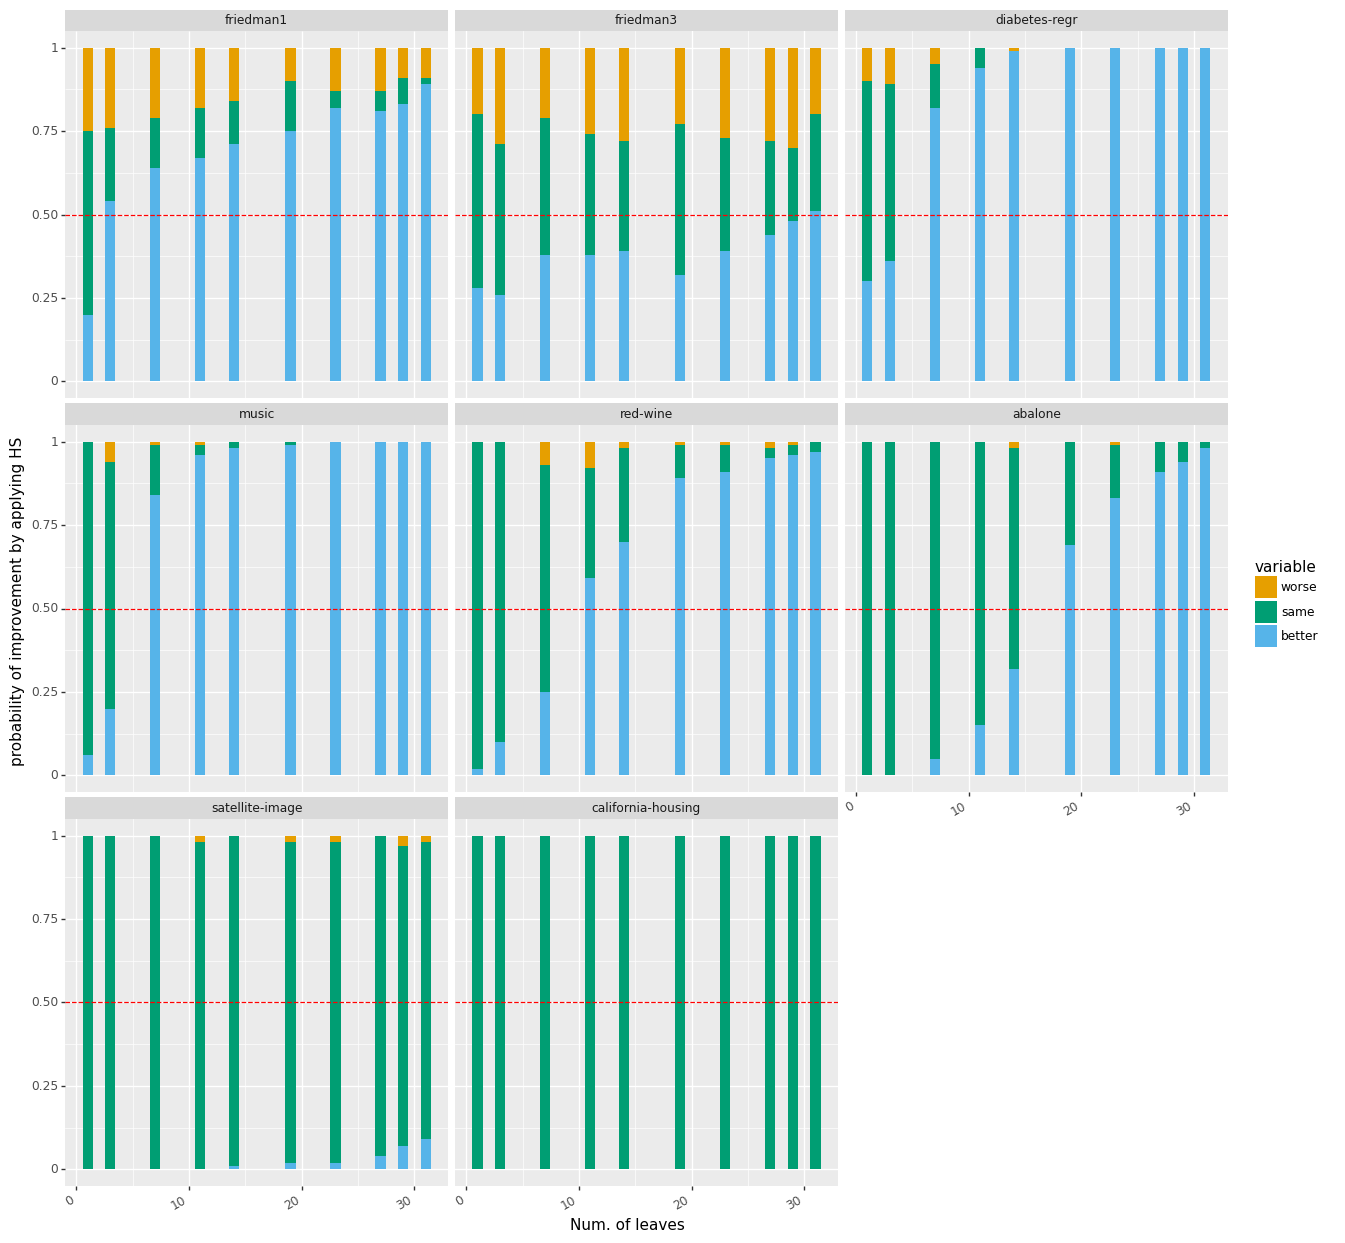

<ggplot: (8767568451251)>

In [5]:
leaf_improvement = regression.loc[(regression.algorithm == "HS (CART)")][["dataset", "test_score", "n_leaves"]]
leaf_improvement["dt_score"] = np.array(regression.loc[(regression.algorithm == "DT")]["test_score"])
leaf_improvement["diff"] = np.abs(leaf_improvement["test_score"] - leaf_improvement["dt_score"])
leaf_improvement["better"] = (leaf_improvement["test_score"] > leaf_improvement["dt_score"]) & (leaf_improvement["diff"] > 0.005)
leaf_improvement["same"] = (leaf_improvement["diff"] < 0.005)
leaf_improvement["worse"] = (leaf_improvement["test_score"] < leaf_improvement["dt_score"]) & (leaf_improvement["diff"] > 0.005)
leaf_imp_disp = pd.melt(leaf_improvement.groupby(["dataset", "n_leaves"]).mean().reset_index(), id_vars=["dataset", "n_leaves"], value_vars=["better", "same", "worse"])

leaf_imp_disp["dataset"] = pd.Categorical(leaf_imp_disp["dataset"], categories = dataset_order, ordered = True)
leaf_imp_disp["variable"] = pd.Categorical(leaf_imp_disp["variable"], categories = ['worse', "same", 'better'], ordered = True)

g = (ggplot(leaf_imp_disp, aes(fill="variable", y="value", x="n_leaves")) + 
    geom_bar(position="stack", stat="identity") +
    geom_hline(yintercept = [0.5], color = "red", linetype="dashed") +
    xlab("Num. of leaves") +
    ylab("probability of improvement by applying HS") + 
     scale_fill_manual(values=["#E69F00", "#009E73", "#56B4E9"]) + 
    theme(axis_text_x=element_text(rotation=30, hjust=1)) +
    facet_wrap("dataset")
)

display(g)

In [6]:
# save HS improvement to do some bayesian analysis
leaf_improvement = regression.loc[(regression.algorithm == "HS (CART)")][["dataset", "test_score", "n_leaves"]]
leaf_improvement["dt_score"] = np.array(regression.loc[(regression.algorithm == "DT")]["test_score"])
leaf_improvement["diff"] = np.abs(leaf_improvement["test_score"] - leaf_improvement["dt_score"])
leaf_improvement["better"] = (leaf_improvement["test_score"] > leaf_improvement["dt_score"]) & (leaf_improvement["diff"] > 0.005)
leaf_improvement["same"] = (leaf_improvement["diff"] < 0.005)
leaf_improvement["worse"] = (leaf_improvement["test_score"] < leaf_improvement["dt_score"]) & (leaf_improvement["diff"] > 0.005)
leaf_improvement["imp"] = 0
leaf_improvement.loc[leaf_improvement.better, "imp"] = 1
leaf_improvement.loc[leaf_improvement.same, "imp"] = 2
leaf_improvement.loc[leaf_improvement.worse, "imp"] = 3
leaf_improvement["dataset"] = leaf_improvement["dataset"].replace(dataset_order, list(range(8)))
leaf_improvement[["dataset", "imp"]].to_csv("modelling/data/any-regression.csv", index = False)

In [7]:
leaf_improvement = regression.loc[(regression.algorithm == "HS (CART)")][["dataset", "test_score", "n_leaves"]]
leaf_improvement["dt"] = np.array(regression.loc[(regression.algorithm == "DT")]["test_score"])
leaf_improvement["hs"] = leaf_improvement["test_score"]
leaf_improvement = leaf_improvement.drop(["test_score"], axis = 1)

for dataset in np.unique(regression["dataset"]):
    for n_leaves in np.unique(regression["n_leaves"]):
        group_improvement = leaf_improvement.loc[(leaf_improvement.dataset == dataset) & (leaf_improvement.n_leaves == n_leaves)]
        leaf_improvement.loc[(leaf_improvement.dataset == dataset) & (leaf_improvement.n_leaves == n_leaves), "hs"] = np.random.choice(np.array(group_improvement["hs"]), len(group_improvement["hs"]))
        leaf_improvement.loc[(leaf_improvement.dataset == dataset) & (leaf_improvement.n_leaves == n_leaves), "dt"] = np.random.choice(np.array(group_improvement["dt"]), len(group_improvement["dt"]))
        
leaf_improvement["diff"] = np.abs(leaf_improvement["hs"] - leaf_improvement["dt"])
leaf_improvement["better"] = (leaf_improvement["hs"] > leaf_improvement["dt"]) & (leaf_improvement["diff"] > 0.005)
leaf_improvement["same"] = (leaf_improvement["diff"] < 0.005)
leaf_improvement["worse"] = (leaf_improvement["hs"] < leaf_improvement["dt"]) & (leaf_improvement["diff"] > 0.005)
leaf_improvement["imp"] = 0
leaf_improvement.loc[leaf_improvement.better, "imp"] = 1
leaf_improvement.loc[leaf_improvement.same, "imp"] = 2
leaf_improvement.loc[leaf_improvement.worse, "imp"] = 3
leaf_improvement["dataset"] = leaf_improvement["dataset"].replace(dataset_order, list(range(8)))
leaf_improvement[["dataset", "imp"]].to_csv("modelling/data/random-regression.csv", index = False)

#### Classification

,task,dataset,boot_iter,algorithm,scoring,n_leaves,max_leaves,regularization,train_score,test_score,train_wall_time,test_wall_time,train_cpu_time,test_cpu_time,tunning_wall_time,tunning_cpu_time
0,classification,heart,0,DT,AUC,1,2,None,0.760000,0.680000,0.000346,0.000124,0.000344,0.000124,NaN,NaN
1,classification,heart,0,HS (CART),AUC,1,2,25.0,0.760000,0.680000,0.000106,0.000112,0.000107,0.000113,0.013177,0.013298
2,classification,heart,0,DT,AUC,3,4,None,0.864250,0.863000,0.000349,0.000119,0.000349,0.000120,NaN,NaN
3,classification,heart,0,HS (CART),AUC,3,4,1.0,0.864250,0.863000,0.000136,0.000116,0.000136,0.000117,0.015152,0.015154
4,classification,heart,0,DT,AUC,7,8,None,0.914000,0.883750,0.000360,0.000134,0.000360,0.000134,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,classification,recidivism,99,HS (CART),AUC,27,28,100.0,0.767420,0.723390,0.000662,0.000515,0.000662,0.000515,0.065993,0.065994
15996,classification,recidivism,99,DT,AUC,29,30,None,0.770873,0.719165,0.003724,0.000447,0.003723,0.000448,NaN,NaN
15997,classification,recidivism,99,HS (CART),AUC,29,30,100.0,0.768487,0.723435,0.000438,0.000435,0.000438,0.000436,0.066314,0.066305
15998,classification,recidivism,99,DT,AUC,31,32,None,0.772336,0.714142,0.003777,0.000443,0.003776,0.000443,NaN,NaN


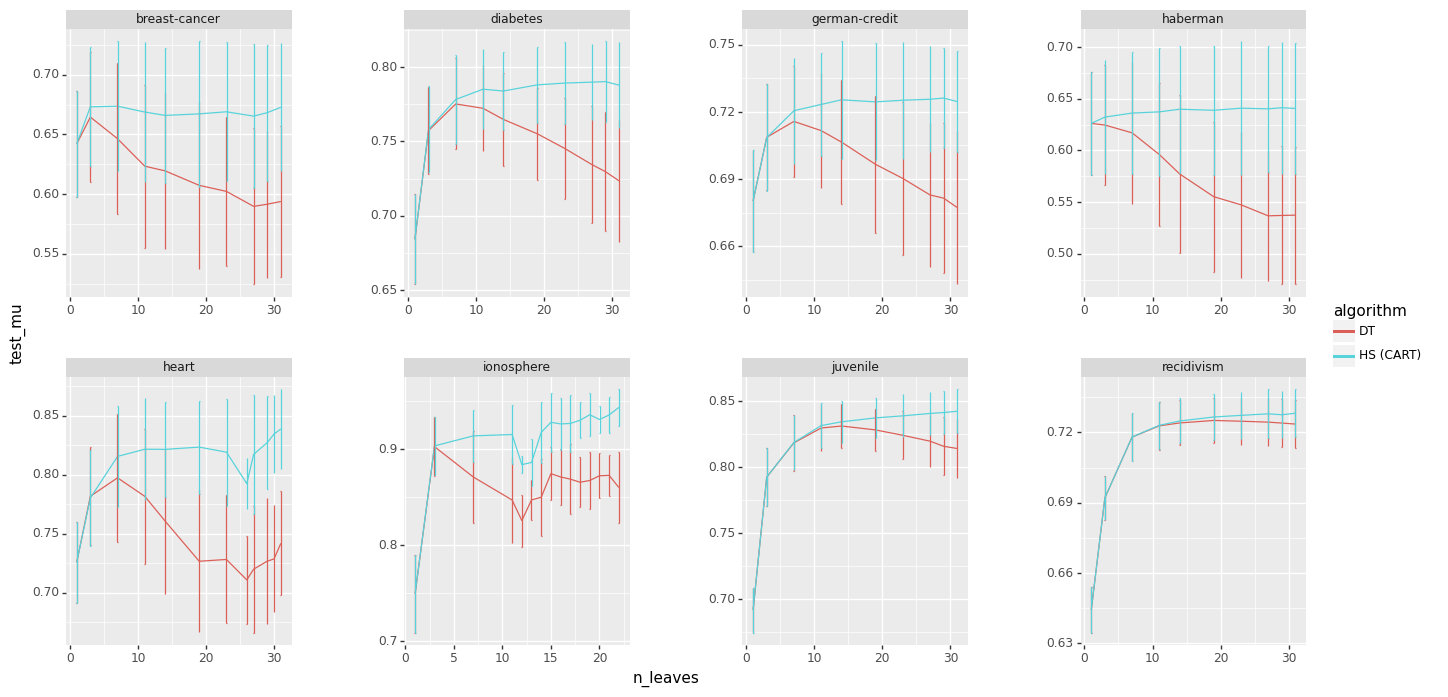

<ggplot: (8767568665522)>

In [8]:
classification = pd.read_csv("results/claim_1_1_dt_comparison_classification.csv")
og_classification = classification.copy()
display(classification)

# drop points with small sample size (reduce noise)
prunned_classification = classification.copy()

for algorithm in classification["algorithm"].unique():
    for dataset in classification["dataset"].unique():
        for n_leaves in classification["n_leaves"].unique():
            if len(prunned_classification.loc[(prunned_classification["n_leaves"] == n_leaves) & (prunned_classification["algorithm"] == algorithm) & (prunned_classification["dataset"] == dataset)]) < 10:
                prunned_classification = prunned_classification.loc[(prunned_classification["n_leaves"] != n_leaves) | (prunned_classification["algorithm"] != algorithm) | (prunned_classification["dataset"] != dataset)]

prunned_classification

plot_fig_4(prunned_classification)

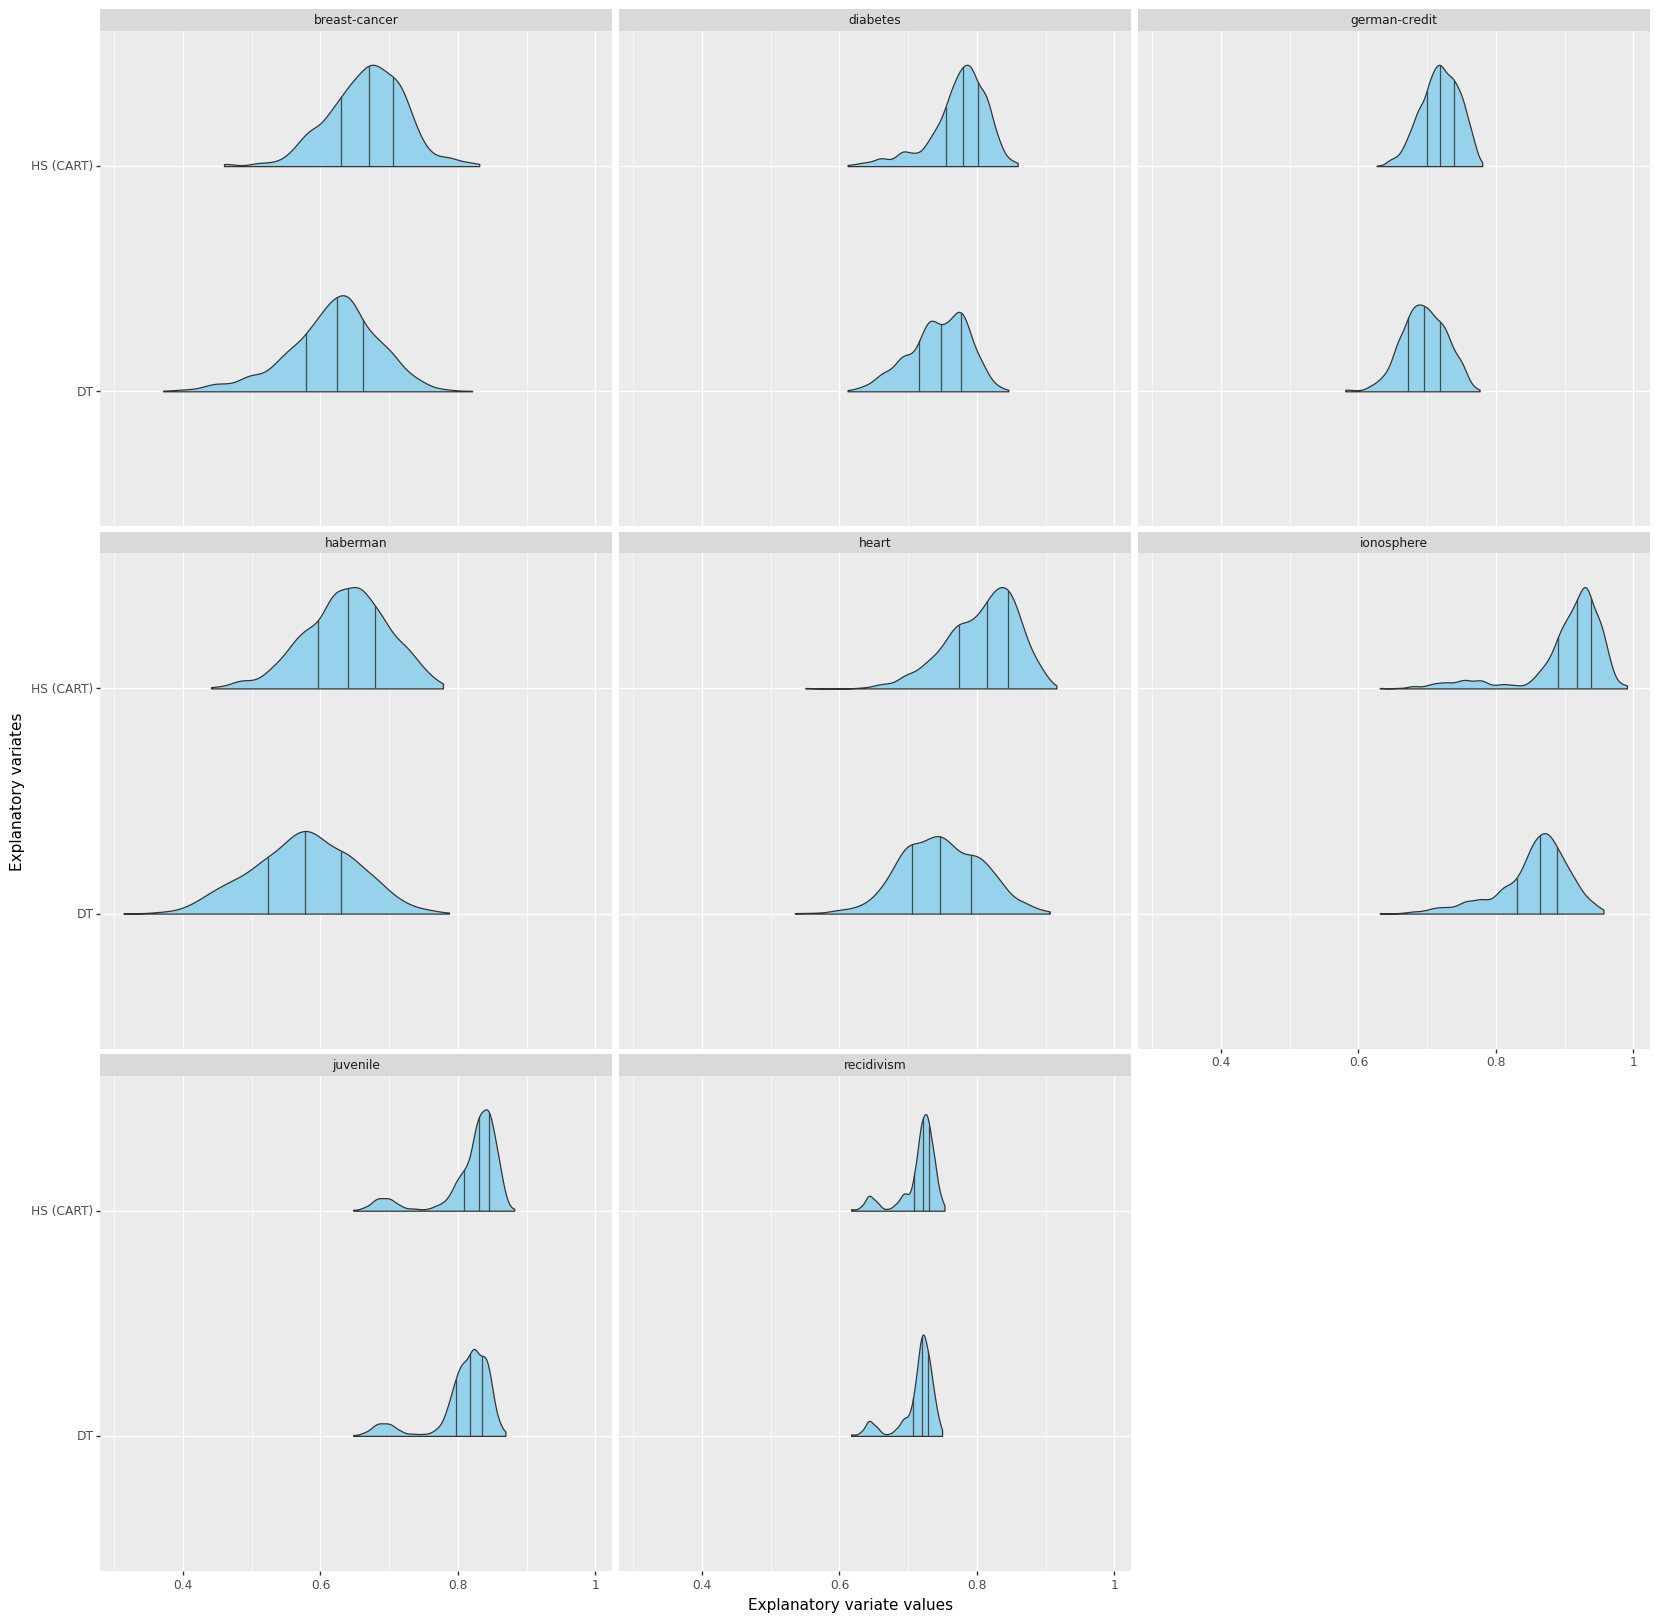

<ggplot: (8767566355589)>

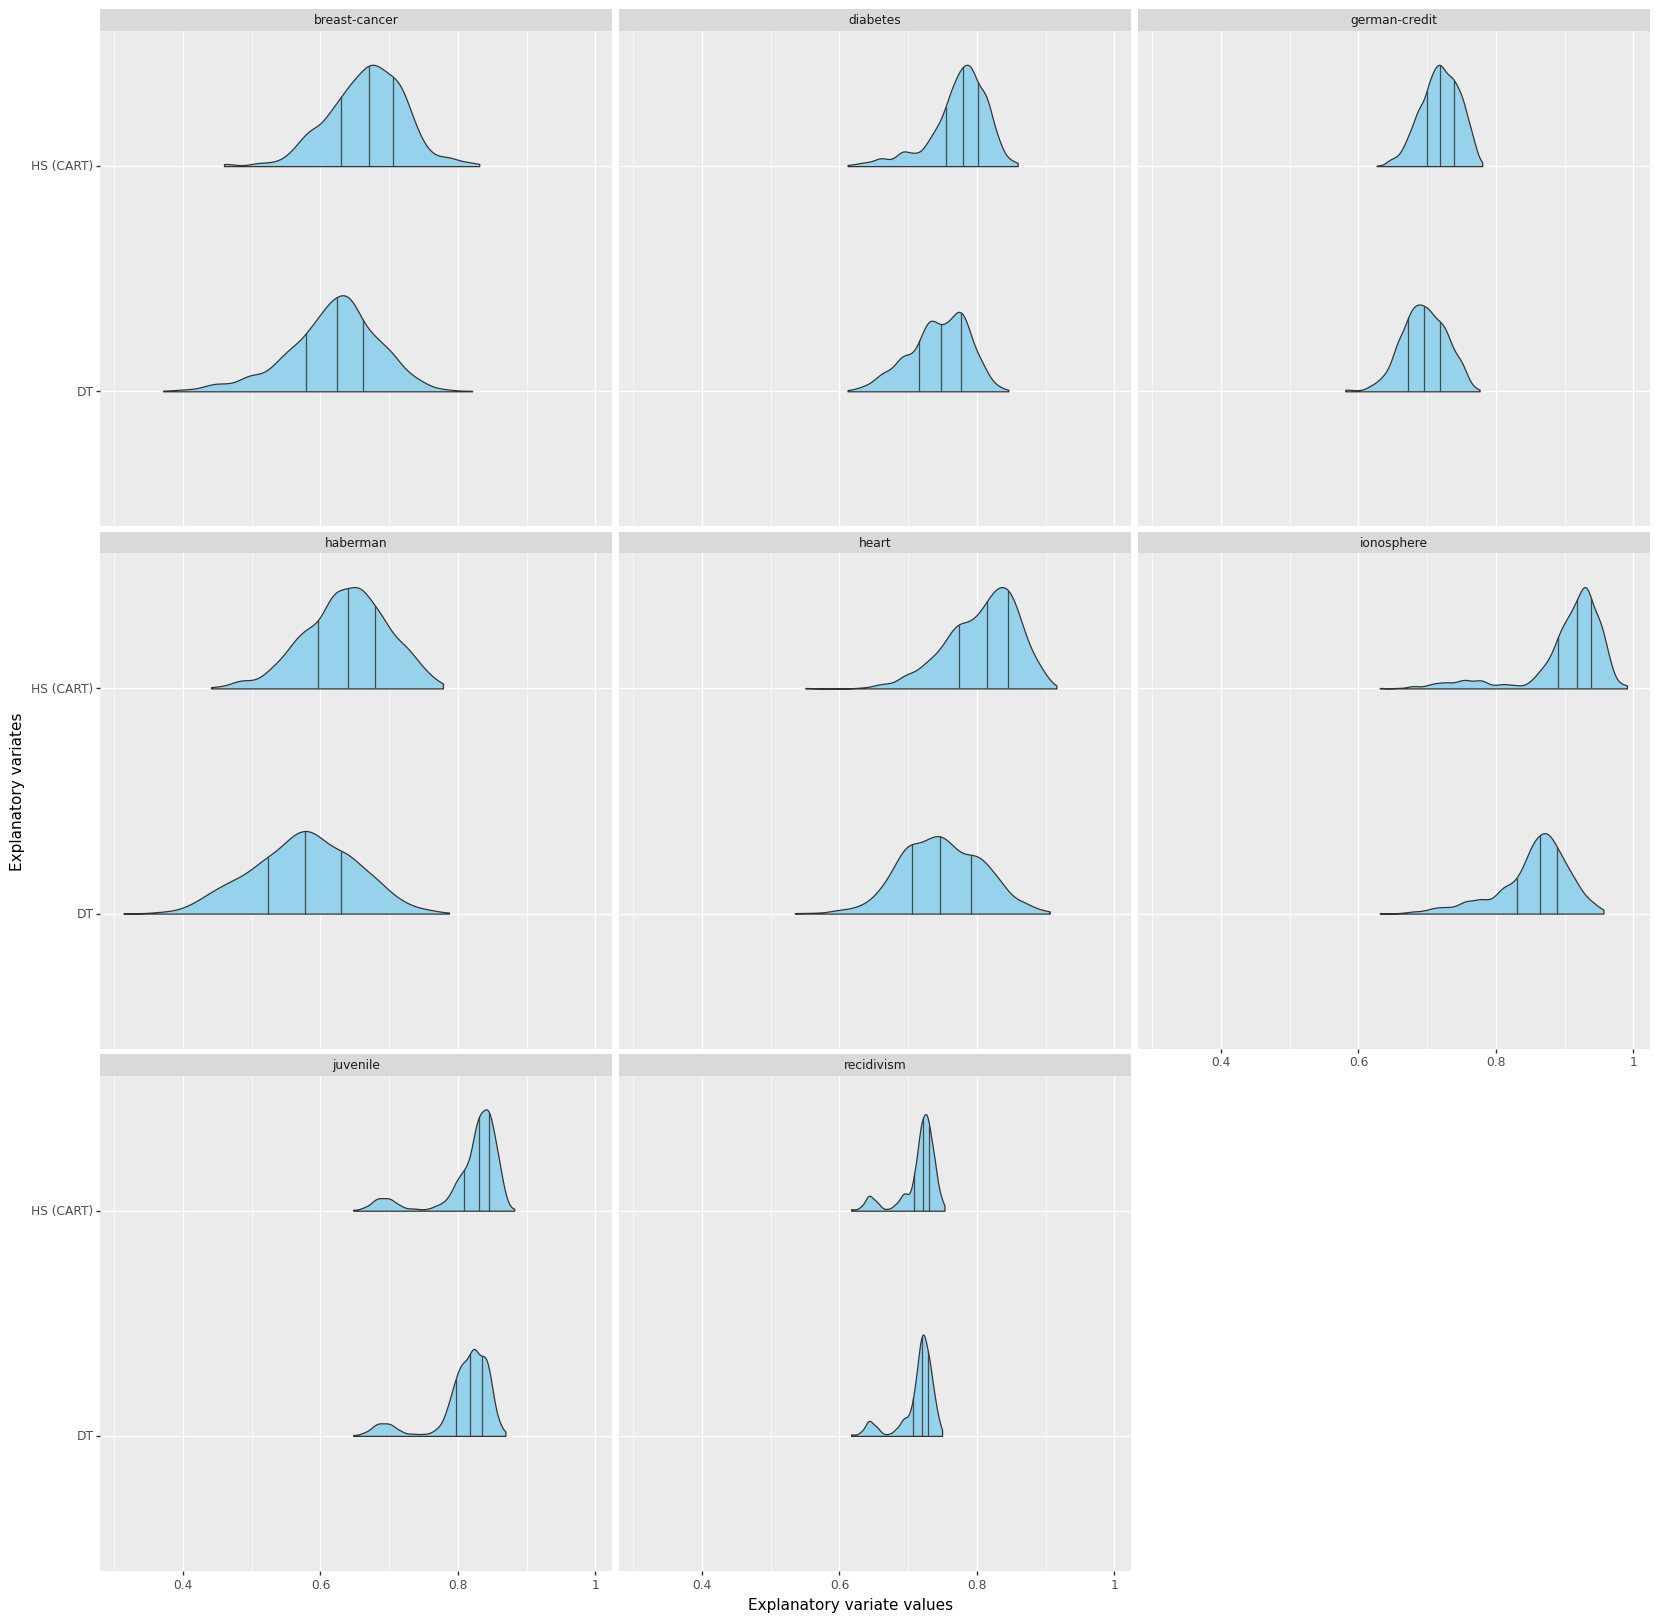

<ggplot: (8767565793959)>

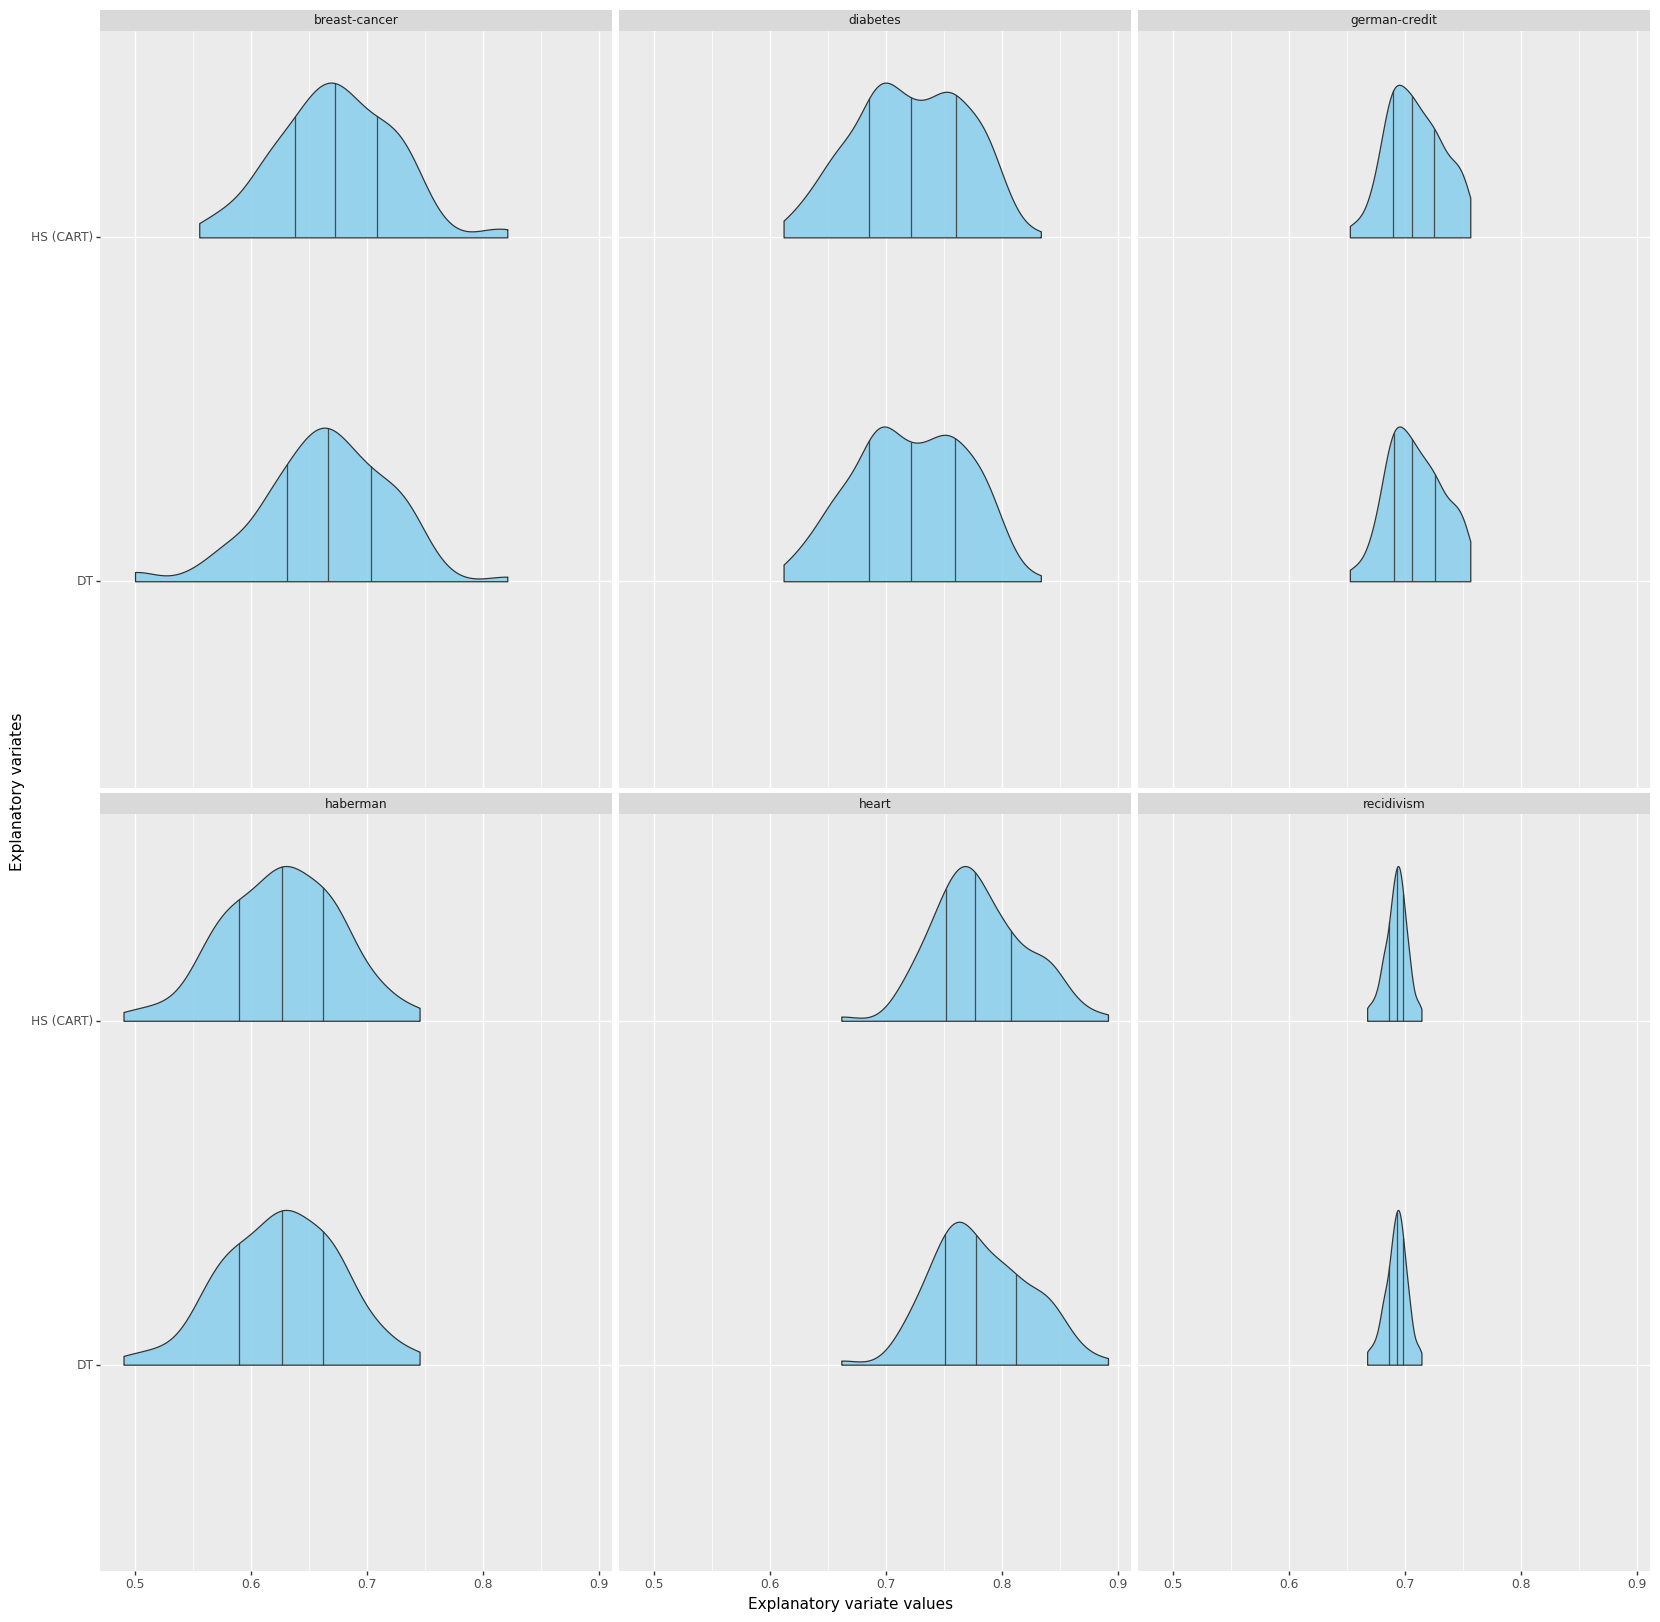

<ggplot: (8767565979970)>

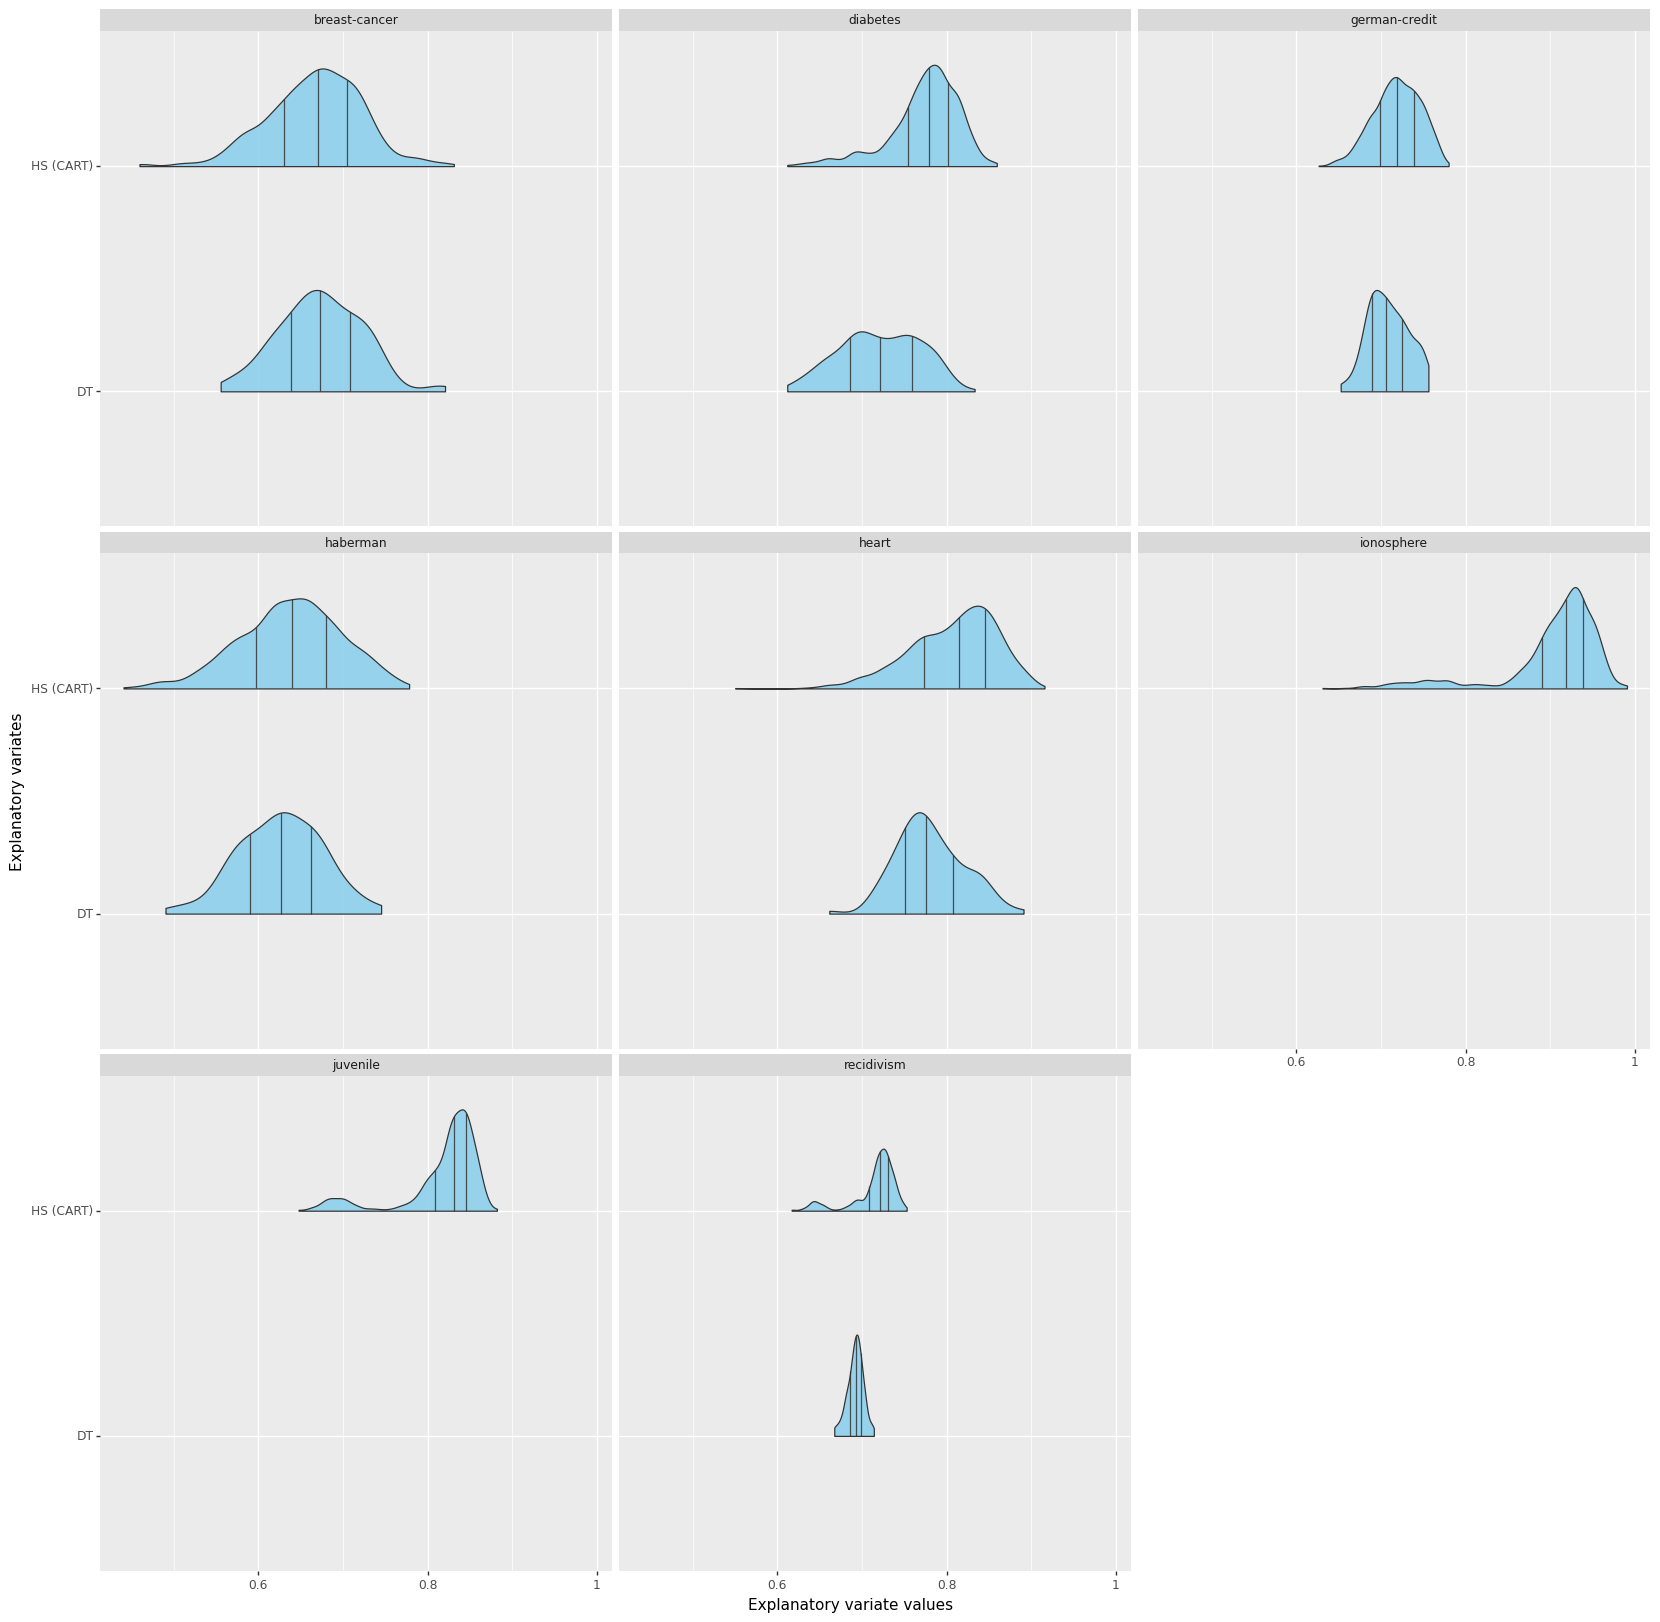

<ggplot: (8767566321508)>

In [9]:
# change plotnine size for easier visualization
plotnine.options.figure_size = (20, 20)

### Pick top best n-scores from HS-DT and DT (95 % quantile)

top_scores = {algorithm: {dataset: [] for dataset in np.unique(classification["dataset"])} for algorithm in np.unique(classification["algorithm"])}

# traverse through all groups of (algorithm, dataset)
for algorithm in np.unique(classification["algorithm"]):
    for dataset in np.unique(classification["dataset"]):
        # sort values in each group from largest to smallest
        scores = classification.loc[(classification["algorithm"] == algorithm) & (classification["dataset"] == dataset)].sort_values(["test_score"], ascending = False)["test_score"].to_numpy()
        
        # pick only the top 0.05 scores from each group
        num_scores = len(scores)
        top_percentile = int(np.round(Q_95 * num_scores))
        top_score = scores[:top_percentile]
        
        # store results
        top_scores[algorithm][dataset] = top_score

# convert results to dataset
top_disp = pd.DataFrame(columns = ["algorithm", "dataset", "test_score"])
        
for algorithm in np.unique(classification["algorithm"]):
    for dataset in np.unique(classification["dataset"]):
        for score in top_scores[algorithm][dataset]:
            top_disp = pd.concat([top_disp, pd.DataFrame({"algorithm": [algorithm], "dataset": [dataset], "test_score": score})])
            
# calculate likelihood that HS-DT is better than DT
top_improvement = {dataset: None  for dataset in np.unique(classification["dataset"])}
for dataset in np.unique(classification["dataset"]):
    # get top results for each algorithm
    top_subset_dt = top_disp.loc[(top_disp["algorithm"] == "DT") & (top_disp["dataset"] == dataset)]
    top_subset_hs = top_disp.loc[(top_disp["algorithm"] == "HS (CART)") & (top_disp["dataset"] == dataset)]
    # compare randomly sampled pairs of top results which one is better
    top_improvement[dataset] = likelihood_of_being_better(np.array(top_subset_dt["test_score"]), np.array(top_subset_hs["test_score"]))

### Check how likely it is that HS-CART will give you a better result than CART day-to-day
any_improvement = {dataset: None  for dataset in np.unique(classification["dataset"])}
    
for dataset in np.unique(classification["dataset"]):
    # get top results for each algorithm 
    any_subset_dt = classification.loc[(classification["algorithm"] == "DT") & (classification["dataset"] == dataset)]
    any_subset_hs = classification.loc[(classification["algorithm"] == "HS (CART)") & (classification["dataset"] == dataset)]
    # compare randomly sampled pairs of results which one is better
    any_improvement[dataset] = likelihood_of_improvement(np.array(any_subset_dt["test_score"]), np.array(any_subset_hs["test_score"]))
        
### Check how likely it is that using default parameters someone will get a better reults using HS-CART than CART

TOL_LEAF = 2 # tolarence for deviation from ideal num. of leaves

# default leaf values sqrt(num. of features)
leaf_heuristic = {"heart": np.floor(np.sqrt(15)),
                  "breast-cancer": np.floor(np.sqrt(17)),
                  "haberman": np.floor(np.sqrt(3)),
                  "ionosphere": np.floor(np.sqrt(34)),
                  "diabetes": np.floor(np.sqrt(8)),
                  "german-credit": np.floor(np.sqrt(20)),
                  "juvenile": np.floor(np.sqrt(286)),
                  "recidivism": np.floor(np.sqrt(20))}

heuristic_scores = classification.copy()
heuristic_scores = {algorithm: {dataset: [] for dataset in np.unique(classification["dataset"])} for algorithm in np.unique(classification["algorithm"])}

# for each group (algorithm, dataset)
for dataset in np.unique(classification["dataset"]):
    n_leaves = leaf_heuristic[dataset]
    for algorithm in np.unique(classification["algorithm"]):
        # pick points near ideal number of leaves
        heuristic_scores[algorithm][dataset] = np.array(classification.loc[(classification["algorithm"] == algorithm) & (classification["dataset"] == dataset) & (np.abs(classification["n_leaves"] - n_leaves) < TOL_LEAF)]["test_score"])

# convert dictionary to dataset
heuristic_disp = pd.DataFrame(columns = ["algorithm", "dataset", "test_score"])
        
for algorithm in np.unique(classification["algorithm"]):
    for dataset in np.unique(classification["dataset"]):
        for score in heuristic_scores[algorithm][dataset]:
            heuristic_disp = pd.concat([heuristic_disp, pd.DataFrame({"algorithm": [algorithm], "dataset": [dataset], "test_score": score})])

# calculate likelihood of improvement
heuristic_improvement = {dataset: None  for dataset in np.unique(classification["dataset"])}
for dataset in np.unique(classification["dataset"]):
    # split points based on dataset
    heuristic_subset_dt = heuristic_disp.loc[(heuristic_disp["algorithm"] == "DT") & (heuristic_disp["dataset"] == dataset)]
    heuristic_subset_hs = heuristic_disp.loc[(heuristic_disp["algorithm"] == "HS (CART)") & (heuristic_disp["dataset"] == dataset)]
    # compare randomly sampled pairs of results which one is better
    heuristic_improvement[dataset] = likelihood_of_improvement(np.array(heuristic_subset_dt["test_score"]), np.array(heuristic_subset_hs["test_score"]))
            
# default / proposed # of features
baseline_scores = classification.copy()

baseline_scores = {algorithm: {dataset: [] for dataset in np.unique(classification["dataset"])} for algorithm in np.unique(classification["algorithm"])}

for dataset in np.unique(classification["dataset"]):
    n_leaves = leaf_heuristic[dataset]
    baseline_scores["DT"][dataset] = np.array(classification.loc[(classification["algorithm"] == algorithm) & (classification["dataset"] == dataset) & (np.abs(classification["n_leaves"] - n_leaves) < TOL_LEAF)]["test_score"])
    baseline_scores["HS (CART)"][dataset] = np.array(classification.loc[(classification["algorithm"] == algorithm) & (classification["dataset"] == dataset)]["test_score"])
        
baseline_disp = pd.DataFrame(columns = ["algorithm", "dataset", "test_score"])
        
for algorithm in np.unique(classification["algorithm"]):
    for dataset in np.unique(classification["dataset"]):
        for score in baseline_scores[algorithm][dataset]:
            baseline_disp = pd.concat([baseline_disp, pd.DataFrame({"algorithm": [algorithm], "dataset": [dataset], "test_score": score})])
            
baseline_improvement = {dataset: None  for dataset in np.unique(classification["dataset"])}
for dataset in np.unique(classification["dataset"]):
    baseline_subset_dt = baseline_disp.loc[(baseline_disp["algorithm"] == "DT") & (baseline_disp["dataset"] == dataset)]
    baseline_subset_hs = baseline_disp.loc[(baseline_disp["algorithm"] == "HS (CART)") & (baseline_disp["dataset"] == dataset)]
    baseline_improvement[dataset] = likelihood_of_being_better(np.array(baseline_subset_dt["test_score"]), np.array(baseline_subset_hs["test_score"]))
            
# probability as a function of leaves
leaf_scores = {algorithm: {dataset: {n_leaves: None for n_leaves in np.unique(classification["n_leaves"])} for dataset in np.unique(classification["dataset"])} for algorithm in np.unique(classification["algorithm"])}
for algorithm in np.unique(classification["algorithm"]):
    for dataset in np.unique(classification["dataset"]):
        for n_leaves in np.unique(classification["n_leaves"]):
            leaf_scores[algorithm][dataset][n_leaves] = np.array(classification.loc[(classification["algorithm"] == algorithm) & (classification["dataset"] == dataset) & (np.abs(classification["n_leaves"] - n_leaves) < 0.5)]["test_score"])

leaf_disp = pd.DataFrame(columns = ["algorithm", "dataset", "test_score"])

for algorithm in np.unique(classification["algorithm"]):
    for dataset in np.unique(classification["dataset"]):
        for n_leaves in np.unique(classification["n_leaves"]):
            for score in leaf_scores[algorithm][dataset][n_leaves]:
                leaf_disp = pd.concat([leaf_disp, pd.DataFrame({"algorithm": [algorithm], "dataset": [dataset], "n_leaves": n_leaves, "test_score": score})])

leaf_improvement = {dataset: {n_leaves: None for n_leaves in np.unique(classification["n_leaves"])}  for dataset in np.unique(classification["dataset"])}
for dataset in np.unique(classification["dataset"]):
    for n_leaves in np.unique(classification["n_leaves"]):
        leaf_subset_dt = leaf_disp.loc[(leaf_disp["algorithm"] == "DT") & (leaf_disp["dataset"] == dataset)]
        leaf_subset_hs = leaf_disp.loc[(leaf_disp["algorithm"] == "HS (CART)") & (leaf_disp["dataset"] == dataset)]
        leaf_improvement[dataset][n_leaves] = likelihood_of_being_better(np.array(leaf_subset_dt["test_score"]), np.array(leaf_subset_hs["test_score"]))
                
with warnings.catch_warnings(record=True) as future_warn:    
    g = (
        ggplot(top_disp, aes(x="algorithm", y="test_score"))
        + geom_violin(draw_quantiles = [0.25, 0.5, 0.75], fill = "skyblue", alpha = 0.85, style = "right", position = position_dodge())
        + ylab("Explanatory variate values")
        + xlab("Explanatory variates")
        + coord_flip()
        + facet_wrap("dataset")
    )
    
    display(g)
    g.save(filename = "graphs/DT-classification-all-comparison.png", height = 5, width = 5, units = "in", dpi = 1000)

    # pick all scores from HS-DT
    g = (
        ggplot(classification, aes(x="algorithm", y="test_score"))
        + geom_violin(draw_quantiles = [0.25, 0.5, 0.75], fill = "skyblue", alpha = 0.85, style = "right", position = position_dodge())
        + ylab("Explanatory variate values")
        + xlab("Explanatory variates")
        + coord_flip()
        + facet_wrap("dataset")
    )
    display(g)
    g.save(filename = "graphs/DT-classification-any-comparison.png", height = 5, width = 5, units = "in", dpi = 1000)    
    
    g = (
        ggplot(heuristic_disp, aes(x="algorithm", y="test_score"))
        + geom_violin(draw_quantiles = [0.25, 0.5, 0.75], fill = "skyblue", alpha = 0.85, style = "right", position = position_dodge())
        + ylab("Explanatory variate values")
        + xlab("Explanatory variates")
        + coord_flip()
        + facet_wrap("dataset")
    )
    
    display(g)
    g.save(filename = "graphs/DT-classification-heuristic-comparison.png", height = 5, width = 5, units = "in", dpi = 1000)
    
    g = (
        ggplot(baseline_disp, aes(x="algorithm", y="test_score"))
        + geom_violin(draw_quantiles = [0.25, 0.5, 0.75], fill = "skyblue", alpha = 0.85, style = "right", position = position_dodge())
        + ylab("Explanatory variate values")
        + xlab("Explanatory variates")
        + coord_flip()
        + facet_wrap("dataset")
    )
    
    display(g)
    g.save(filename = "graphs/DT-classification-baseline-comparison.png", height = 5, width = 5, units = "in", dpi = 1000)

Top


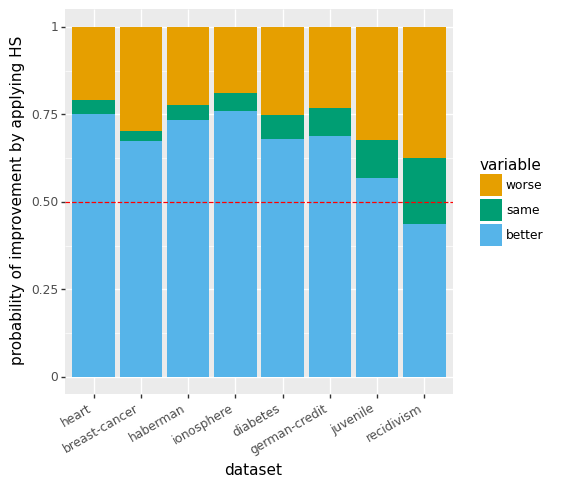

<ggplot: (8767568848590)>

/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 5 x 5 in image.
/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: graphs/DT-top-likelihood.png


Any


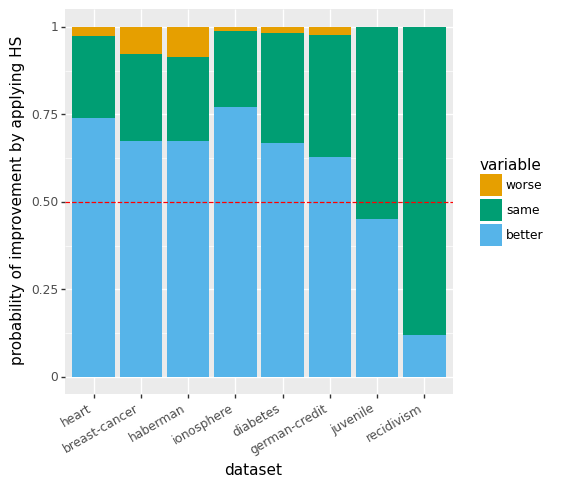

<ggplot: (8767568617205)>

/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 5 x 5 in image.
/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: graphs/DT-any-likelihood.png


Heuristic


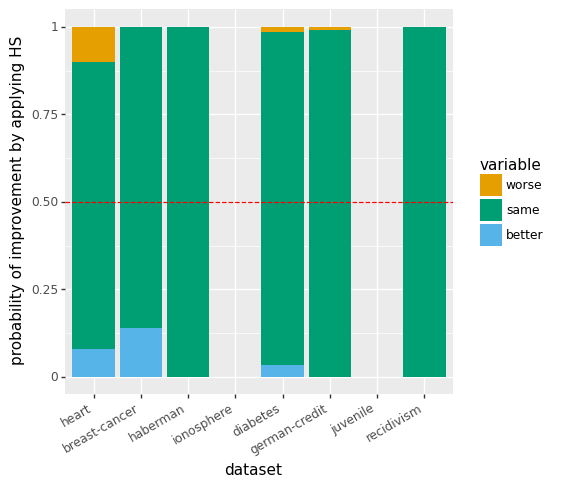

<ggplot: (8767571127417)>

/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 5 x 5 in image.
/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: graphs/DT-heauristic-likelihood.png


Leaves


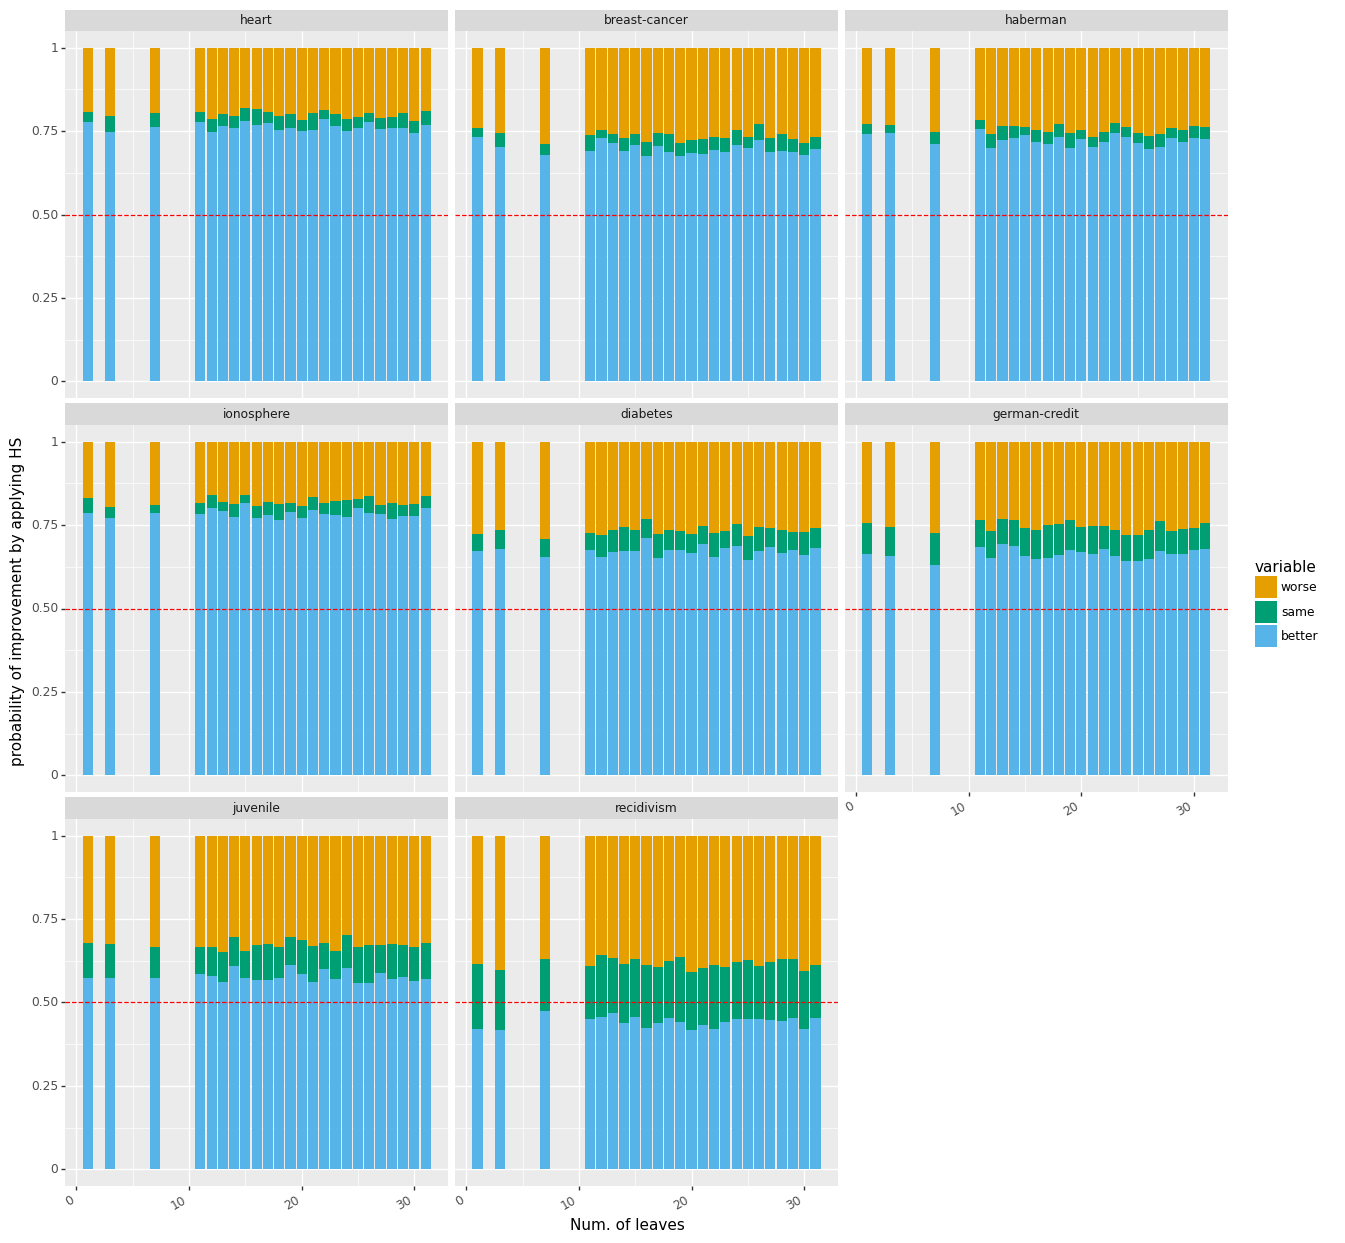

<ggplot: (8767566106763)>

/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 5 x 5 in image.
/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: graphs/DT-leaf-likelihood.png


In [10]:
top_imp_disp = {"dataset": [], "better": [], "worse": [], "same": []}
dataset_order = ["heart", "breast-cancer", "haberman", "ionosphere", "diabetes", "german-credit", "juvenile", "recidivism"]

for dataset in top_improvement.keys():
    top_imp_disp["dataset"].append(dataset)
    top_imp_disp["better"].append(top_improvement[dataset][0])
    top_imp_disp["same"].append(top_improvement[dataset][1])
    top_imp_disp["worse"].append(top_improvement[dataset][2])
top_imp_disp = pd.DataFrame(top_imp_disp)

top_imp_disp = pd.melt(top_imp_disp, id_vars=['dataset'], value_vars=['better', "same", 'worse'])
top_imp_disp["dataset"] = pd.Categorical(top_imp_disp["dataset"], categories = dataset_order, ordered = True)
top_imp_disp["variable"] = pd.Categorical(top_imp_disp["variable"], categories = ['worse', "same", 'better'], ordered = True)

any_imp_disp = {"dataset": [], "better": [], "worse": [], "same": []}

for dataset in top_improvement.keys():
    any_imp_disp["dataset"].append(dataset)
    any_imp_disp["better"].append(any_improvement[dataset][0])
    any_imp_disp["same"].append(any_improvement[dataset][1])
    any_imp_disp["worse"].append(any_improvement[dataset][2])
any_imp_disp = pd.DataFrame(any_imp_disp)

any_imp_disp = pd.melt(any_imp_disp, id_vars=['dataset'], value_vars=['better', "same", 'worse'])
any_imp_disp["dataset"] = pd.Categorical(any_imp_disp["dataset"], categories = dataset_order, ordered = True)
any_imp_disp["variable"] = pd.Categorical(any_imp_disp["variable"], categories = ['worse', "same", 'better'], ordered = True)

heuristic_imp_disp = {"dataset": [], "better": [], "worse": [], "same": []}

for dataset in heuristic_improvement.keys():
    heuristic_imp_disp["dataset"].append(dataset)
    heuristic_imp_disp["better"].append(heuristic_improvement[dataset][0])
    heuristic_imp_disp["same"].append(heuristic_improvement[dataset][1])
    heuristic_imp_disp["worse"].append(heuristic_improvement[dataset][2])
heuristic_imp_disp = pd.DataFrame(heuristic_imp_disp)

heuristic_imp_disp = pd.melt(heuristic_imp_disp, id_vars=['dataset'], value_vars=['better', "same", 'worse'])
heuristic_imp_disp["dataset"] = pd.Categorical(heuristic_imp_disp["dataset"], categories = dataset_order, ordered = True)
heuristic_imp_disp["variable"] = pd.Categorical(heuristic_imp_disp["variable"], categories = ['worse', "same", 'better'], ordered = True)

baseline_imp_disp = {"dataset": [], "better": [], "worse": [], "same": []}

for dataset in baseline_improvement.keys():
    baseline_imp_disp["dataset"].append(dataset)
    baseline_imp_disp["better"].append(baseline_improvement[dataset][0])
    baseline_imp_disp["same"].append(baseline_improvement[dataset][1])
    baseline_imp_disp["worse"].append(baseline_improvement[dataset][2])
baseline_imp_disp = pd.DataFrame(baseline_imp_disp)

baseline_imp_disp = pd.melt(baseline_imp_disp, id_vars=['dataset'], value_vars=['better', "same", 'worse'])
baseline_imp_disp["dataset"] = pd.Categorical(baseline_imp_disp["dataset"], categories = dataset_order, ordered = True)
baseline_imp_disp["variable"] = pd.Categorical(baseline_imp_disp["variable"], categories = ['worse', "same", 'better'], ordered = True)

leaf_imp_disp = {"dataset": [], "n_leaves": [], "better": [], "worse": [], "same": []}

for dataset in leaf_improvement.keys():
    for n_leaves in leaf_improvement[dataset].keys():
        leaf_imp_disp["dataset"].append(dataset)
        leaf_imp_disp["n_leaves"].append(n_leaves)
        leaf_imp_disp["better"].append(leaf_improvement[dataset][n_leaves][0])
        leaf_imp_disp["same"].append(leaf_improvement[dataset][n_leaves][1])
        leaf_imp_disp["worse"].append(leaf_improvement[dataset][n_leaves][2])
leaf_imp_disp = pd.DataFrame(leaf_imp_disp)

leaf_imp_disp = pd.melt(leaf_imp_disp, id_vars=['dataset', "n_leaves"], value_vars=['better', "same", 'worse'])
leaf_imp_disp["dataset"] = pd.Categorical(leaf_imp_disp["dataset"], categories = dataset_order, ordered = True)
leaf_imp_disp["variable"] = pd.Categorical(leaf_imp_disp["variable"], categories = ['worse', "same", 'better'], ordered = True)

plotnine.options.figure_size = (5, 5)

print("Top")
g = (ggplot(top_imp_disp, aes(fill="variable", y="value", x="dataset")) + 
    geom_bar(position="stack", stat="identity") +
    geom_hline(yintercept = [0.5], color = "red", linetype="dashed") +
    xlab("dataset") +
    ylab("probability of improvement by applying HS") + 
     scale_fill_manual(values=["#E69F00", "#009E73", "#56B4E9"]) + 
    theme(axis_text_x=element_text(rotation=30, hjust=1))
)

display(g)

g.save(filename = "graphs/DT-top-likelihood.png", height = 5, width = 5, units = "in", dpi = 1000)

print("Any")
g = (ggplot(any_imp_disp, aes(fill="variable", y="value", x="dataset")) + 
    geom_bar(position="stack", stat="identity") +
    geom_hline(yintercept = [0.5], color = "red", linetype="dashed") +
    xlab("dataset") +
    ylab("probability of improvement by applying HS") + 
     scale_fill_manual(values=["#E69F00", "#009E73", "#56B4E9"]) + 
    theme(axis_text_x=element_text(rotation=30, hjust=1))
)

display(g)

g.save(filename = "graphs/DT-any-likelihood.png", height = 5, width = 5, units = "in", dpi = 1000)

print("Heuristic")
g = (ggplot(heuristic_imp_disp, aes(fill="variable", y="value", x="dataset")) + 
    geom_bar(position="stack", stat="identity") +
    geom_hline(yintercept = [0.5], color = "red", linetype="dashed") +
    xlab("dataset") +
    ylab("probability of improvement by applying HS") + 
     scale_fill_manual(values=["#E69F00", "#009E73", "#56B4E9"]) + 
    theme(axis_text_x=element_text(rotation=30, hjust=1))
)

display(g)

g.save(filename = "graphs/DT-heauristic-likelihood.png", height = 5, width = 5, units = "in", dpi = 1000)

plotnine.options.figure_size = (15, 15)

print("Leaves")
g = (ggplot(leaf_imp_disp, aes(fill="variable", y="value", x="n_leaves")) + 
    geom_bar(position="stack", stat="identity") +
    geom_hline(yintercept = [0.5], color = "red", linetype="dashed") +
    xlab("Num. of leaves") +
    ylab("probability of improvement by applying HS") + 
     scale_fill_manual(values=["#E69F00", "#009E73", "#56B4E9"]) + 
    theme(axis_text_x=element_text(rotation=30, hjust=1)) +
    facet_wrap("dataset")
)

display(g)

g.save(filename = "graphs/DT-leaf-likelihood.png", height = 5, width = 5, units = "in", dpi = 1000)

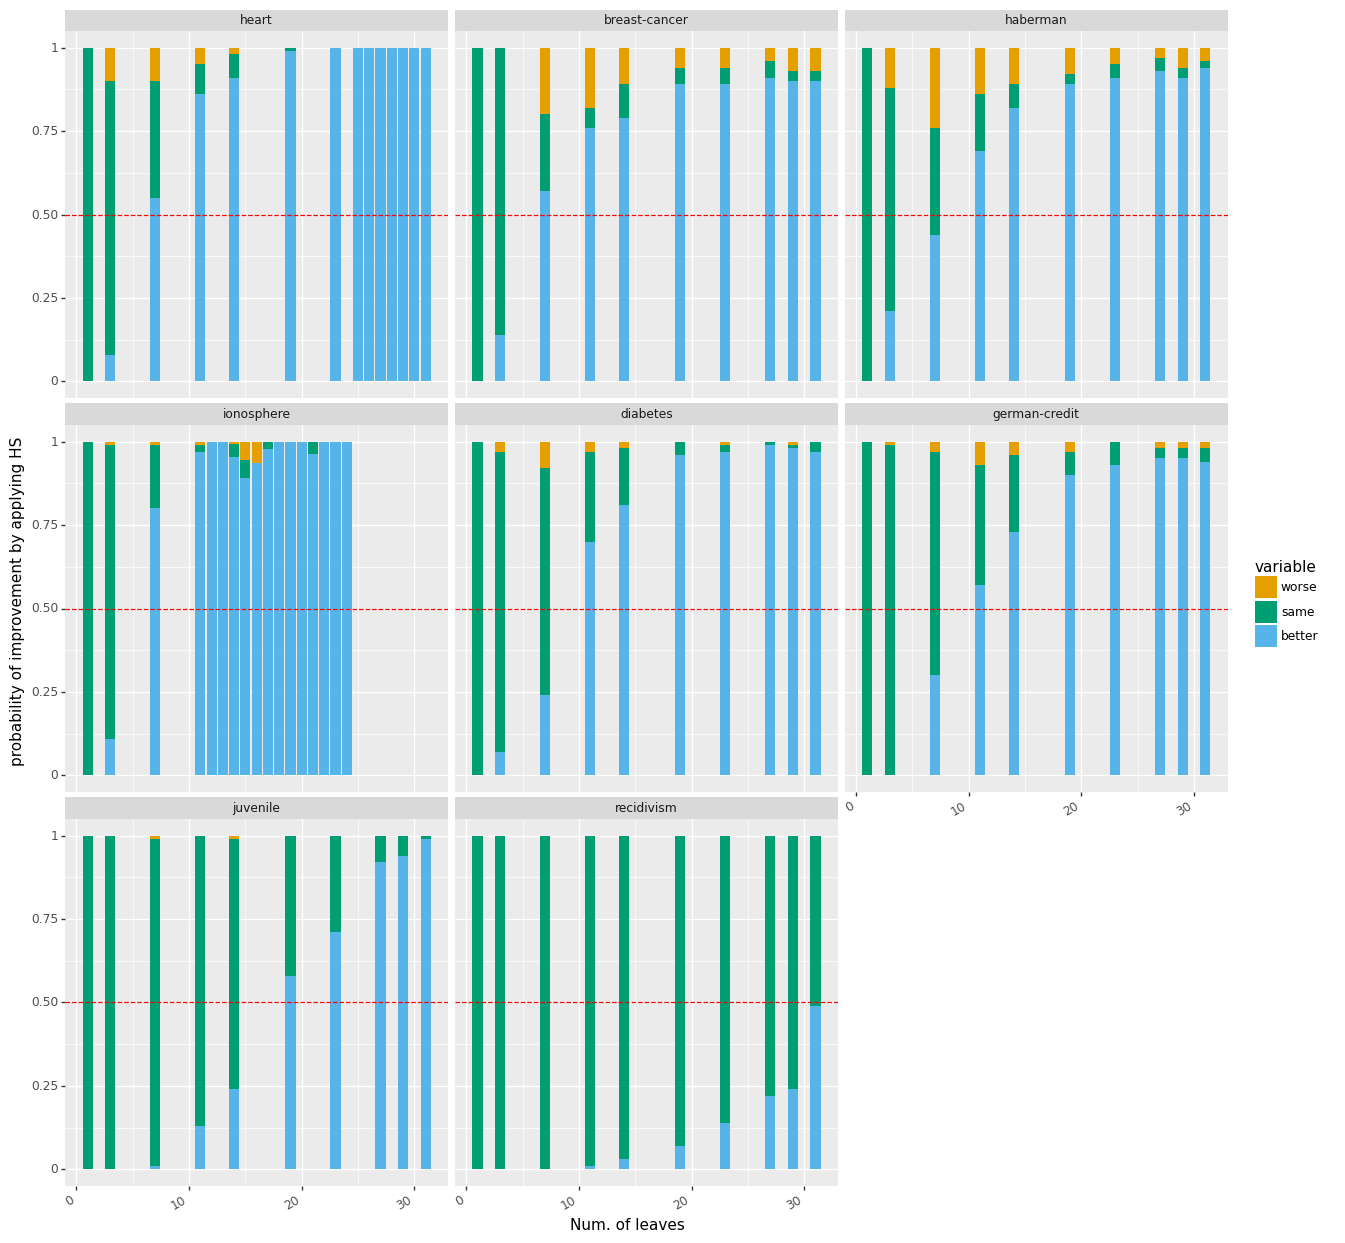

<ggplot: (8767568089070)>

In [11]:
leaf_improvement = classification.loc[(classification.algorithm == "HS (CART)")][["dataset", "test_score", "n_leaves"]]
leaf_improvement["dt_score"] = np.array(classification.loc[(classification.algorithm == "DT")]["test_score"])
leaf_improvement["diff"] = np.abs(leaf_improvement["test_score"] - leaf_improvement["dt_score"])
leaf_improvement["better"] = (leaf_improvement["test_score"] > leaf_improvement["dt_score"]) & (leaf_improvement["diff"] > 0.005)
leaf_improvement["same"] = (leaf_improvement["diff"] < 0.005)
leaf_improvement["worse"] = (leaf_improvement["test_score"] < leaf_improvement["dt_score"]) & (leaf_improvement["diff"] > 0.005)
leaf_imp_disp = pd.melt(leaf_improvement.groupby(["dataset", "n_leaves"]).mean().reset_index(), id_vars=["dataset", "n_leaves"], value_vars=["better", "same", "worse"])

leaf_imp_disp["dataset"] = pd.Categorical(leaf_imp_disp["dataset"], categories = dataset_order, ordered = True)
leaf_imp_disp["variable"] = pd.Categorical(leaf_imp_disp["variable"], categories = ['worse', "same", 'better'], ordered = True)

g = (ggplot(leaf_imp_disp, aes(fill="variable", y="value", x="n_leaves")) + 
    geom_bar(position="stack", stat="identity") +
    geom_hline(yintercept = [0.5], color = "red", linetype="dashed") +
    xlab("Num. of leaves") +
    ylab("probability of improvement by applying HS") + 
     scale_fill_manual(values=["#E69F00", "#009E73", "#56B4E9"]) + 
    theme(axis_text_x=element_text(rotation=30, hjust=1)) +
    facet_wrap("dataset")
)

display(g)

Save dataset for R modelling.

In [12]:
# save HS improvement to do some bayesian analysis
leaf_improvement = classification.loc[(classification.algorithm == "HS (CART)")][["dataset", "test_score", "n_leaves"]]
leaf_improvement["dt_score"] = np.array(classification.loc[(classification.algorithm == "DT")]["test_score"])
leaf_improvement["diff"] = np.abs(leaf_improvement["test_score"] - leaf_improvement["dt_score"])
leaf_improvement["better"] = (leaf_improvement["test_score"] > leaf_improvement["dt_score"]) & (leaf_improvement["diff"] > 0.005)
leaf_improvement["same"] = (leaf_improvement["diff"] < 0.005)
leaf_improvement["worse"] = (leaf_improvement["test_score"] < leaf_improvement["dt_score"]) & (leaf_improvement["diff"] > 0.005)
leaf_improvement["imp"] = 0
leaf_improvement.loc[leaf_improvement.better, "imp"] = 1
leaf_improvement.loc[leaf_improvement.same, "imp"] = 2
leaf_improvement.loc[leaf_improvement.worse, "imp"] = 3
leaf_improvement["dataset"] = leaf_improvement["dataset"].replace(dataset_order, list(range(8)))
leaf_improvement[["dataset", "imp"]].to_csv("modelling/data/any-classification.csv", index = False)

In [13]:
leaf_improvement = classification.loc[(classification.algorithm == "HS (CART)")][["dataset", "test_score", "n_leaves"]]
leaf_improvement["dt"] = np.array(classification.loc[(classification.algorithm == "DT")]["test_score"])
leaf_improvement["hs"] = leaf_improvement["test_score"]
leaf_improvement = leaf_improvement.drop(["test_score"], axis = 1)

for dataset in np.unique(classification["dataset"]):
    for n_leaves in np.unique(classification["n_leaves"]):
        group_improvement = leaf_improvement.loc[(leaf_improvement.dataset == dataset) & (leaf_improvement.n_leaves == n_leaves)]
        leaf_improvement.loc[(leaf_improvement.dataset == dataset) & (leaf_improvement.n_leaves == n_leaves), "hs"] = np.random.choice(np.array(group_improvement["hs"]), len(group_improvement["hs"]))
        leaf_improvement.loc[(leaf_improvement.dataset == dataset) & (leaf_improvement.n_leaves == n_leaves), "dt"] = np.random.choice(np.array(group_improvement["dt"]), len(group_improvement["dt"]))
        
leaf_improvement["diff"] = np.abs(leaf_improvement["hs"] - leaf_improvement["dt"])
leaf_improvement["better"] = (leaf_improvement["hs"] > leaf_improvement["dt"]) & (leaf_improvement["diff"] > 0.005)
leaf_improvement["same"] = (leaf_improvement["diff"] < 0.005)
leaf_improvement["worse"] = (leaf_improvement["hs"] < leaf_improvement["dt"]) & (leaf_improvement["diff"] > 0.005)
leaf_improvement["imp"] = 0
leaf_improvement.loc[leaf_improvement.better, "imp"] = 1
leaf_improvement.loc[leaf_improvement.same, "imp"] = 2
leaf_improvement.loc[leaf_improvement.worse, "imp"] = 3
leaf_improvement["dataset"] = leaf_improvement["dataset"].replace(dataset_order, list(range(8)))
leaf_improvement[["dataset", "imp"]].to_csv("modelling/data/random-classification.csv", index = False)

# 1.2) CCP

,task,dataset,boot_iter,algorithm,scoring,n_leaves,max_leaves,regularization,train_score,test_score,train_wall_time,test_wall_time,train_cpu_time,test_cpu_time,tunning_wall_time,tunning_cpu_time
0,classification,heart,0,CCP,AUC,30,2,0.000000,1.000000,0.800000,0.000378,0.000147,0.000379,0.000147,0.005468,0.005883
1,classification,heart,0,HS (CART-CCP),AUC,30,2,50.000000,0.982375,0.853000,0.000458,0.000120,0.000458,0.000121,0.091148,0.091149
2,classification,heart,0,CCP,AUC,3,4,0.044615,0.834688,0.801750,0.000401,0.000110,0.000401,0.000111,0.007221,0.007222
3,classification,heart,0,HS (CART-CCP),AUC,3,4,25.000000,0.834437,0.795250,0.000126,0.000114,0.000126,0.000115,0.165957,0.166140
4,classification,heart,0,CCP,AUC,3,8,0.022968,0.834688,0.801750,0.000406,0.000111,0.000406,0.000112,0.013772,0.013773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,classification,recidivism,29,HS (CART-CCP),AUC,7,28,1.000000,0.730377,0.727280,0.000175,0.000386,0.000175,0.000386,5.420331,5.420159
4796,classification,recidivism,29,CCP,AUC,4,30,0.004784,0.714875,0.708951,0.009139,0.000365,0.009140,0.000365,0.504213,0.503934
4797,classification,recidivism,29,HS (CART-CCP),AUC,4,30,25.000000,0.714875,0.708951,0.000139,0.000367,0.000140,0.000367,6.032989,6.032101
4798,classification,recidivism,29,CCP,AUC,11,32,0.001192,0.742044,0.730651,0.009212,0.000403,0.009213,0.000403,0.513648,0.513623


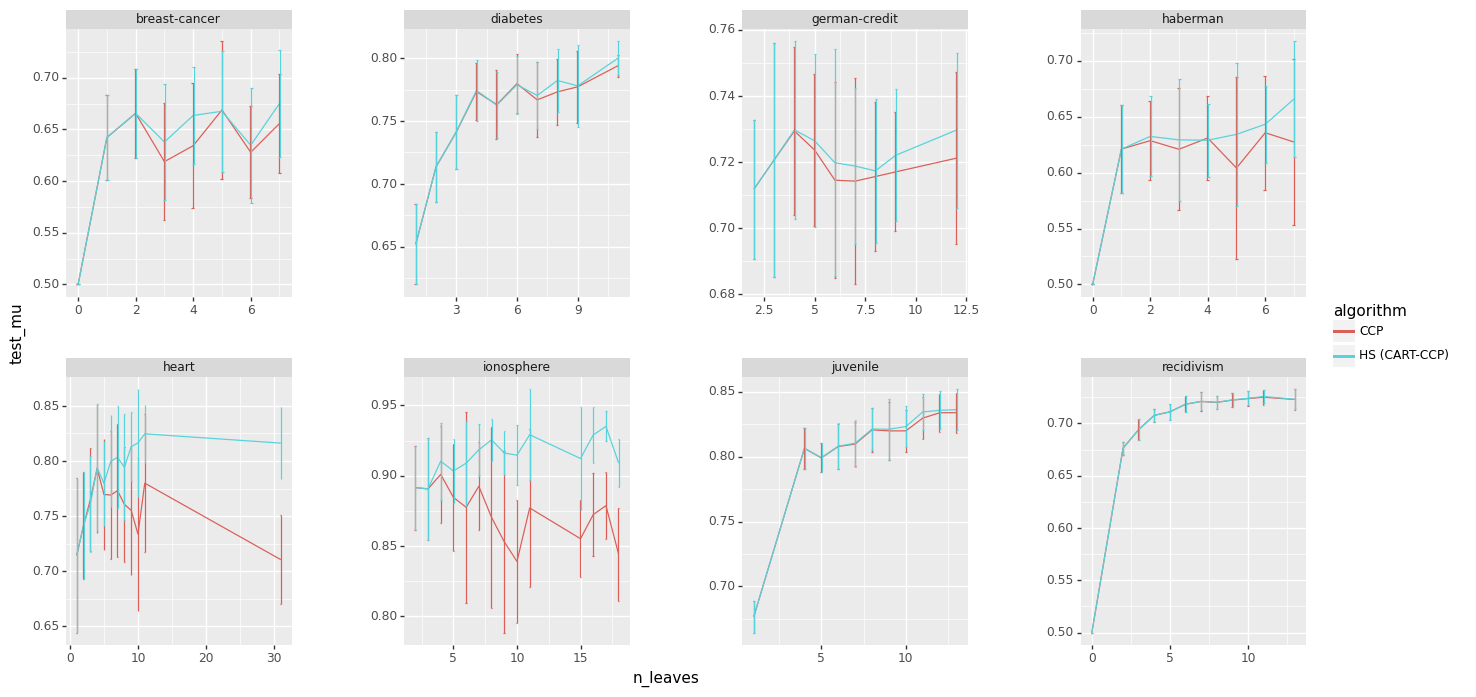

<ggplot: (8767566231757)>

In [14]:
classification = pd.read_csv("results/claim_1_1_ccp_comparison_classification.csv")
display(classification)

# drop points with small sample size (reduce noise)
prunned_classification = classification.copy()

for algorithm in classification["algorithm"].unique():
    for dataset in classification["dataset"].unique():
        for n_leaves in classification["n_leaves"].unique():
            if len(prunned_classification.loc[(prunned_classification["n_leaves"] == n_leaves) & (prunned_classification["algorithm"] == algorithm) & (prunned_classification["dataset"] == dataset)]) < 10:
                prunned_classification = prunned_classification.loc[(prunned_classification["n_leaves"] != n_leaves) | (prunned_classification["algorithm"] != algorithm) | (prunned_classification["dataset"] != dataset)]

prunned_classification

plot_fig_4(prunned_classification)

,task,dataset,boot_iter,algorithm,scoring,n_leaves,max_leaves,regularization,train_score,test_score,train_wall_time,test_wall_time,train_cpu_time,test_cpu_time,tunning_wall_time,tunning_cpu_time
0,classification,heart,0,CCP,AUC,30,2,0.000000,1.000000,0.800000,0.000378,0.000147,0.000379,0.000147,0.005468,0.005883
1,classification,heart,0,HS (CART-CCP),AUC,30,2,50.000000,0.982375,0.853000,0.000458,0.000120,0.000458,0.000121,0.091148,0.091149
2,classification,heart,0,CCP,AUC,3,4,0.044615,0.834688,0.801750,0.000401,0.000110,0.000401,0.000111,0.007221,0.007222
3,classification,heart,0,HS (CART-CCP),AUC,3,4,25.000000,0.834437,0.795250,0.000126,0.000114,0.000126,0.000115,0.165957,0.166140
4,classification,heart,0,CCP,AUC,3,8,0.022968,0.834688,0.801750,0.000406,0.000111,0.000406,0.000112,0.013772,0.013773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,classification,recidivism,29,HS (CART-CCP),AUC,7,28,1.000000,0.730377,0.727280,0.000175,0.000386,0.000175,0.000386,5.420331,5.420159
4796,classification,recidivism,29,CCP,AUC,4,30,0.004784,0.714875,0.708951,0.009139,0.000365,0.009140,0.000365,0.504213,0.503934
4797,classification,recidivism,29,HS (CART-CCP),AUC,4,30,25.000000,0.714875,0.708951,0.000139,0.000367,0.000140,0.000367,6.032989,6.032101
4798,classification,recidivism,29,CCP,AUC,11,32,0.001192,0.742044,0.730651,0.009212,0.000403,0.009213,0.000403,0.513648,0.513623


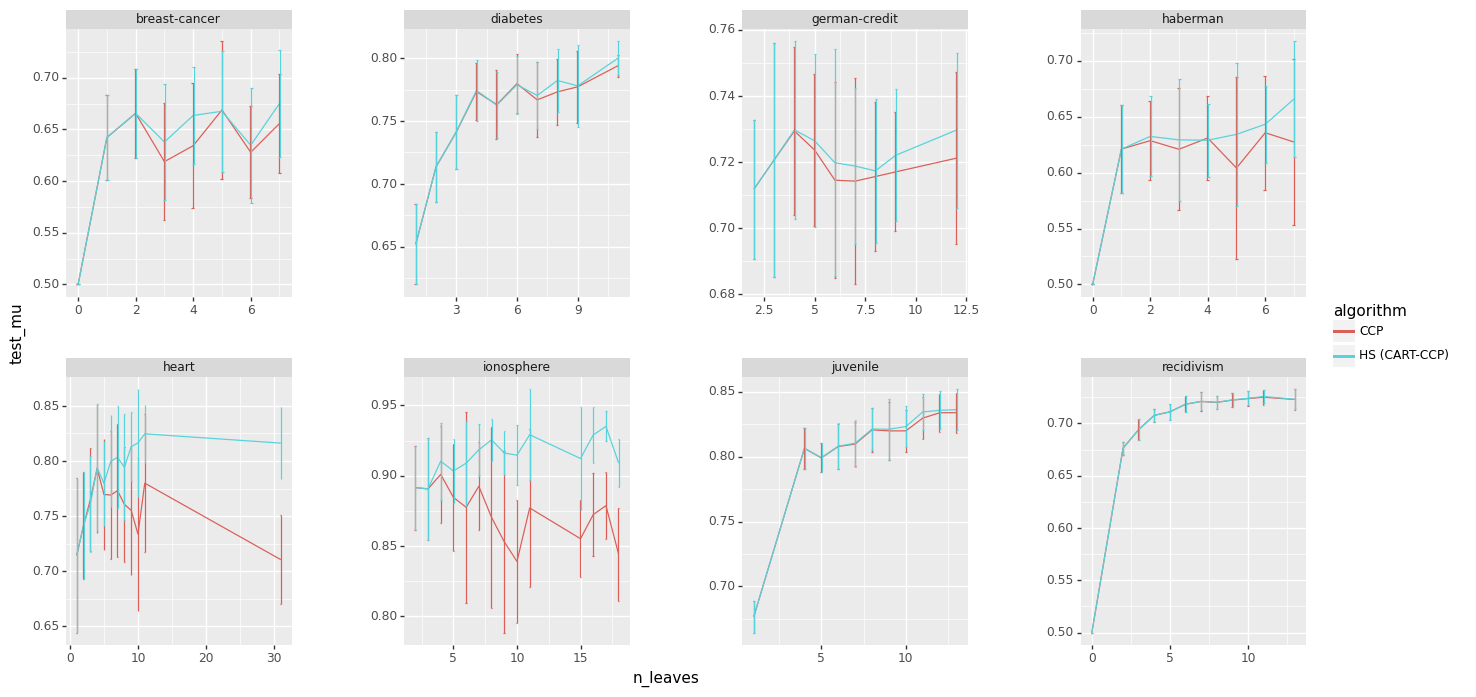

<ggplot: (8767566194118)>

In [15]:
classification = pd.read_csv("results/claim_1_1_ccp_comparison_classification.csv")
display(classification)

# drop points with small sample size (reduce noise)
prunned_classification = classification.copy()

for algorithm in classification["algorithm"].unique():
    for dataset in classification["dataset"].unique():
        for n_leaves in classification["n_leaves"].unique():
            if len(prunned_classification.loc[(prunned_classification["n_leaves"] == n_leaves) & (prunned_classification["algorithm"] == algorithm) & (prunned_classification["dataset"] == dataset)]) < 10:
                prunned_classification = prunned_classification.loc[(prunned_classification["n_leaves"] != n_leaves) | (prunned_classification["algorithm"] != algorithm) | (prunned_classification["dataset"] != dataset)]

prunned_classification

plot_fig_4(prunned_classification)

In [64]:
def closest_pnt(x):
    arr = np.unique(classification["n_leaves"])
    dist = np.array([np.abs(el - x) for el in arr])
    dist_min = np.min(dist)
    
    return arr[np.where(dist_min == dist)][0]

og_classification["n_leaves"] = og_classification["n_leaves"].apply(closest_pnt)

# data for CCP comparison graph
leaf_improvement = classification.loc[(classification.algorithm == "HS (CART-CCP)")][["dataset", "test_score", "n_leaves"]]
leaf_improvement["ccp"] = np.array(classification.loc[(classification.algorithm == "CCP")]["test_score"])
leaf_improvement["hs"]  = 0
leaf_improvement["hs-ccp"] = leaf_improvement["test_score"]
leaf_improvement = leaf_improvement.drop(["test_score"], axis = 1)

for dataset in np.unique(leaf_improvement["dataset"]):
    for n_leaves in np.unique(leaf_improvement["n_leaves"]):
        hs_approx = np.array(og_classification.loc[(og_classification.algorithm == "HS (CART)") & (og_classification.dataset == dataset) & (og_classification.n_leaves == n_leaves), "test_score"])
        if len(hs_approx) > 0.80 * len(group_improvement):
            group_improvement = leaf_improvement.loc[(leaf_improvement.dataset == dataset) & (leaf_improvement.n_leaves == n_leaves)]
            leaf_improvement.loc[(leaf_improvement.dataset == dataset) & (leaf_improvement.n_leaves == n_leaves), "ccp"] = np.random.choice(np.array(group_improvement["ccp"]), len(group_improvement["hs-ccp"]))
            leaf_improvement.loc[(leaf_improvement.dataset == dataset) & (leaf_improvement.n_leaves == n_leaves), "hs"] = np.random.choice(hs_approx, len(group_improvement["hs"]))
            leaf_improvement.loc[(leaf_improvement.dataset == dataset) & (leaf_improvement.n_leaves == n_leaves), "hs-ccp"] = np.random.choice(np.array(group_improvement["hs-ccp"]), len(group_improvement["hs-ccp"]))
        else:
            leaf_improvement = leaf_improvement.loc[~((leaf_improvement.dataset == dataset) & (leaf_improvement.n_leaves == n_leaves))]

max_score = leaf_improvement[["ccp", "hs", "hs-ccp"]].max(axis = 1)

ccp_best = np.array(leaf_improvement["ccp"] >= max_score - 0.005)
hs_best = np.array(leaf_improvement["hs"] >= max_score - 0.005)
hs_ccp_best = np.array(leaf_improvement["hs-ccp"] >= max_score - 0.005)

leaf_improvement["imp"] = 1

hs_df_best = leaf_improvement.copy()
hs_df_best.loc[hs_best, "imp"] = 2
hs_df_best["dataset"] = hs_df_best["dataset"].replace(dataset_order, list(range(8)))
hs_df_best[["dataset", "imp"]].to_csv("modelling/data/reg-hs.csv", index = False)

ccp_df_best = leaf_improvement.copy()
ccp_df_best.loc[ccp_best, "imp"] = 2
ccp_df_best["dataset"] = ccp_df_best["dataset"].replace(dataset_order, list(range(8)))
ccp_df_best[["dataset", "imp"]].to_csv("modelling/data/reg-ccp.csv", index = False)

hs_ccp_df_best = leaf_improvement.copy()
hs_ccp_df_best.loc[hs_ccp_best, "imp"] = 2
hs_ccp_df_best["dataset"] = hs_ccp_df_best["dataset"].replace(dataset_order, list(range(8)))
hs_ccp_df_best[["dataset", "imp"]].to_csv("modelling/data/reg-hsccp.csv", index = False)

In [65]:
leaf_improvement

,dataset,n_leaves,ccp,hs,hs-ccp,imp
1,heart,30,0.740000,0.846250,0.796250,1
3,heart,3,0.695250,0.794500,0.710500,1
5,heart,3,0.695250,0.817250,0.710500,1
9,heart,7,0.753250,0.770250,0.835000,1
11,heart,31,0.755000,0.873250,0.841000,1
...,...,...,...,...,...,...
4765,recidivism,7,0.721358,0.702720,0.733558,1
4775,recidivism,14,0.736619,0.750475,0.718128,1
4793,recidivism,11,0.720866,0.740758,0.726669,1
4795,recidivism,7,0.728516,0.721236,0.721358,1
